In [34]:
# %matplotlib widget
# %matplotlib inline
%matplotlib qt5

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from qick import *
from qick.helpers import gauss

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})
mpl.rcParams['figure.dpi'] = 150

import Pyro4.util

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
linestyle_cycle=['solid', 'dashed', 'dotted', 'dashdot']
marker_cycle = ['o', '*', 's', '^']

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A


c:\ProgramData\Anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [3]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.amplitude_rabi_f0g1
imported experiments.two_qubit.amprabi_opt_ctrl_state_prep
imported experiments.two_qubit.crosstalk_echo_calib
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.length_rabi_F0G1
imported exper

### Set save data

In [4]:
save_data = False

In [5]:
def prev_data(expt_path, filename=None):
    """Reopen saved data"""
    temp_data_file = expt_path
    if filename is not None: temp_data_file = os.path.join(expt_path, filename)
    print(temp_data_file)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [6]:
# expt_path=os.path.join(os.getcwd(), 'data', 'data_240617')
data_path = 'S:\\QRAM\\qram_4QR2\\'
expt_path = os.path.join(data_path, 'data', 'data_250119')
print('Data will be stored in', expt_path)

Data will be stored in S:\QRAM\qram_4QR2\data\data_250119


In [7]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.path.join('s:\\Connie\\experiments\\qram_tprocv1_expts\\configs\\', config_file)
print('Config will be', config_path)

Config will be s:\Connie\experiments\qram_tprocv1_expts\configs\config_q3diamond_full688and638_reset.yml


# Load config

In [8]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [9]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
# im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
# im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium
im = InstrumentManager(ns_address='10.108.30.75') # Spilker Vibranium

print(list(im))
# print(im)

['Pyro.NameServer', 'Qick_QRAM']


In [10]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())

# soc = QickConfig(im['Qick187'].get_cfg())

QICK running on ZCU216, software version 0.2.272

Firmware configuration (built Sat Oct  5 10:21:47 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 32768 samples (4.762 us)
		fs=6881.280 MHz, fabric=430.080 MH

In [11]:
# lo1 = im[yaml_cfg.aliases.readout_LO]
# lo1.open_device()
# print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# # # TURN ON
# # lo1.set_standby(False)
# # lo1.set_output_state(True)
# # lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
# # lo_power = float(yaml_cfg.hw.lo.readout.power)
# # lo1.set_frequency(lo_freq) # Set LO frequency
# # print(f'set freq to [MHz] {lo_freq*1e-6}')
# # lo1.set_power(lo_power) # Set LO power
# # print('set power to', lo_power)

## Set TWPA parameters

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [23]:
"""
TWPA ON
"""

print('Using config file', config_path)
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium

lo_twpa = im[yaml_cfg.aliases.twpa_LO]
# lo_twpa = SignalCore(name="SignalCore", address='10003494')
lo_twpa.open_device()
print(lo_twpa.get_id())

# TURN ON
lo_twpa.set_standby(False)
lo_twpa.set_output_state(True)
twpa_freq = float(yaml_cfg.hw.lo.twpa.frequency)
twpa_power = float(yaml_cfg.hw.lo.twpa.power)
lo_twpa.set_frequency(twpa_freq) # Set LO frequency
print(f'set twpa pump freq to {twpa_freq*1e-6} MHz')
lo_twpa.set_power(twpa_power) # Set LO power
print(f'set twpa pump power to {twpa_power} dBm')

Using config file s:\Connie\experiments\qram_tprocv1_expts\configs\config_q3diamond_full688and638_reset.yml
Default Instrument SC_26C1
set twpa pump freq to 8194.0 MHz
set twpa pump power to -0.6 dBm


In [ ]:
"""
TWPA OFF
"""
im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium

lo_twpa = im[yaml_cfg.aliases.twpa_LO]
# lo_twpa = SignalCore(name="SignalCore", address='10003494')
lo_twpa.open_device()
print(lo_twpa.get_id())

# TURN OFF
lo_twpa.set_standby(True)
lo_twpa.set_output_state(False)

# Qubit/resonator to probe

In [11]:
all_results = [dict(), dict(), dict(), dict()]
saved_files = []

In [12]:
qubit_i = 2
results_Qi = all_results[qubit_i]

In [13]:
full_mux_expt = False
resonator_reset = [0, 2, 3] if full_mux_expt else None
use_robust_pulses = True

## Set reps and rounds

In [14]:
reps = 100
rounds = 10

# RFSoC Calibration

In [16]:
tof = meas.ToFCalibrationExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"adc_trig_offset_calibration_qubit{qubit_i}",
    config_file=config_path,
)

tof.cfg.expt = dict(
    pulse_length=0.5, # [us]
    readout_length=1.0, # [us]
    trig_offset=0, # [clock ticks]
    # gain=32000,
    gain=0.8, # [MUX units: -1 to 1]
    frequency=tof.cfg.device.readout.frequency[qubit_i]-15, # [MHz]
    reps=reps*rounds, # Number of averages per point
    # qubit=qubit_i,
    qubit=qubit_i,
)
tof.cfg.device.readout.relax_delay=0.1 # wait time between experiments [us]
# print(tof.cfg)

try:
    tof.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

215 307
readout freq 7200 + 487.42095511476606


  0%|          | 0/1000 [00:00<?, ?it/s]

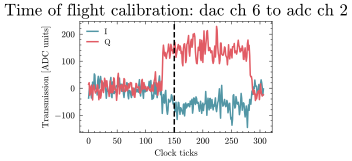

In [17]:
tof.display(adc_trig_offset=150)

# Initial single tone resonator spectroscopy

In [47]:
rspec = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
rspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 1.0 # MHz
npts = 150
rspec.cfg.expt = dict(
    start=rspec.cfg.device.readout.frequency[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=reps*rounds,
    pulse_e=False, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qTest=qubit_i,
    qZZ=None,

    resonator_reset=resonator_reset,
    full_mux_expt=full_mux_expt,
)
# rspec.cfg.device.readout.gain[qubit_i] /= 3
# rspec.cfg.device.readout.readout_length = [3*rspec.cfg.device.readout.readout_length[qubit_i]]*4

rspec.cfg.device.readout.relax_delay = 25 # Wait time between experiments [us] - should be 5x resonator lifetime for good shape

try:
    rspec.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/150 [00:00<?, ?it/s]

electrical delay phase correction (no mux support) (deg) 5.947832662956577
param guess [5795.766817394013, 28978.834086970062, 28978.834086970062, 0, -0.03366808433115601, 0.8802564647558864]
param bounds ([5795.276817394014, 0, 0, -6.283185307179586, -0.05050212649673402, -inf], [5796.2568173940135, 1000000000.0, 100000000.0, 6.283185307179586, 0.05050212649673402, 1.0108576266793154])
popt [ 5.79577597e+03  8.11579530e+04  8.00990188e+04  4.11901175e-01
  2.83267452e-02 -3.88881318e-02]

Freq with minimum transmission: 5795.776817394014
Freq with maximum transmission: 5795.510150727347
From fit:
	f0: 5795.775968322405
	Qi: 81157.95300201827 	 kappa_i/2pi: 0.07141353070078385
	Qe: 80099.01883284768 	 kappa_e/2pi: 0.0723576399907863
	Q0: 40312.504519810755
	kappa [MHz]: 0.14377117069157014
	phi [radians]: 0.41190117453252634
baseline 81.35654856089734


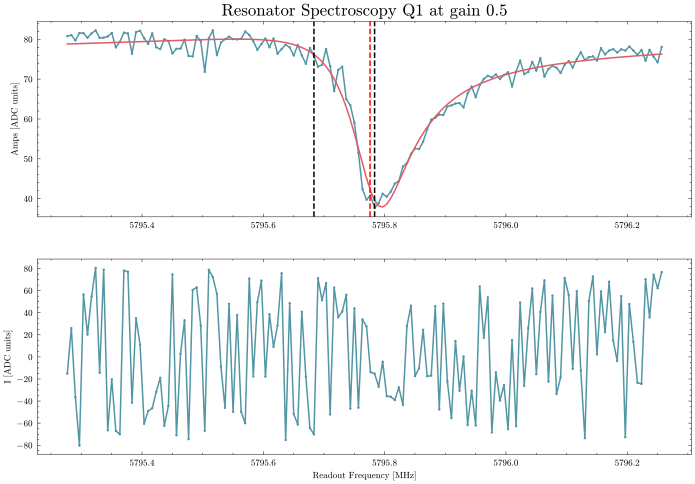

*Set cfg res 1 freq to 5795.78348406068*
qubit 1 {'Res freq': 5795.78348406068, 'Res freq (yaml)': 5795.78348406068, 'Res kappa': 0.14377117069157014}


In [48]:
# TESTING
# # rspec = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspec.data = temp_data

rspec.data = rspec.analyze(fit=True)
rspec_fit = rspec.data['fit']
# if not isinstance(rspec_fit, (list, np.ndarray)):
#     rspec.display(fit=False)
#     assert False, 'Fit failed, please manually fix!'
rspec.display(fit=True)
# yaml_cfg.device.readout.frequency[qubit_i] = rspec_fit[0]

res_freq_g = rspec.data['xpts'][np.argmin(rspec.data['amps'])]
# res_freq_g = rspec.data['xpts'][np.argmax(rspec.data['amps'])]
yaml_cfg.device.readout.frequency[qubit_i] = res_freq_g

print(f'*Set cfg res {qubit_i} freq to {yaml_cfg.device.readout.frequency[qubit_i]}*')
results_Qi.update({'Res freq':float(yaml_cfg.hw.lo.readout.frequency)*1e-6 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.device.readout.frequency[qubit_i] + yaml_cfg.hw.soc.dacs.readout.mixer_freq[qubit_i])})
results_Qi.update({'Res freq (yaml)':yaml_cfg.device.readout.frequency[qubit_i]})
results_Qi.update({'Res kappa':abs(rspec_fit[0]*(1/rspec_fit[1] + 1/rspec_fit[2]))})
print(f'qubit {qubit_i}', results_Qi)

In [21]:
if save_data: saved_files.append(rspec.save_data())

# Qubit ge spectroscopy

## Pulse Probe (qubit) spectroscopy

In [71]:
qspec = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 50
npts = 250

qspec.cfg.expt = dict(
    start=np.reshape(yaml_cfg.device.qubit.f_ge, (4,4))[qubit_i, qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=reps, # Number of averages per point
    rounds=rounds, # Number of start to finish sweeps to average over
    length=1, # Qubit probe constant pulse length [us]
    gain=int(np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.gain, (4,4))[qubit_i, qubit_i]/400), # Qubit pulse gain
    pulse_type='gauss',
    qTest=qubit_i,
    qZZ=None,
    checkEF=False,
)
qspec.cfg.device.readout.relax_delay = 30 # Wait time between experiments [us]
qspec.go(analyze=False, display=False, progress=True, save=False)

Running pulse probe on Q3 


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4378.488696848801, HWHM 0.5555318238624206
Found peak in I at [MHz] 4378.462102329069, HWHM -0.5532133854549539
Found peak in Q at [MHz] 4378.488236250658, HWHM 0.5564594611454907


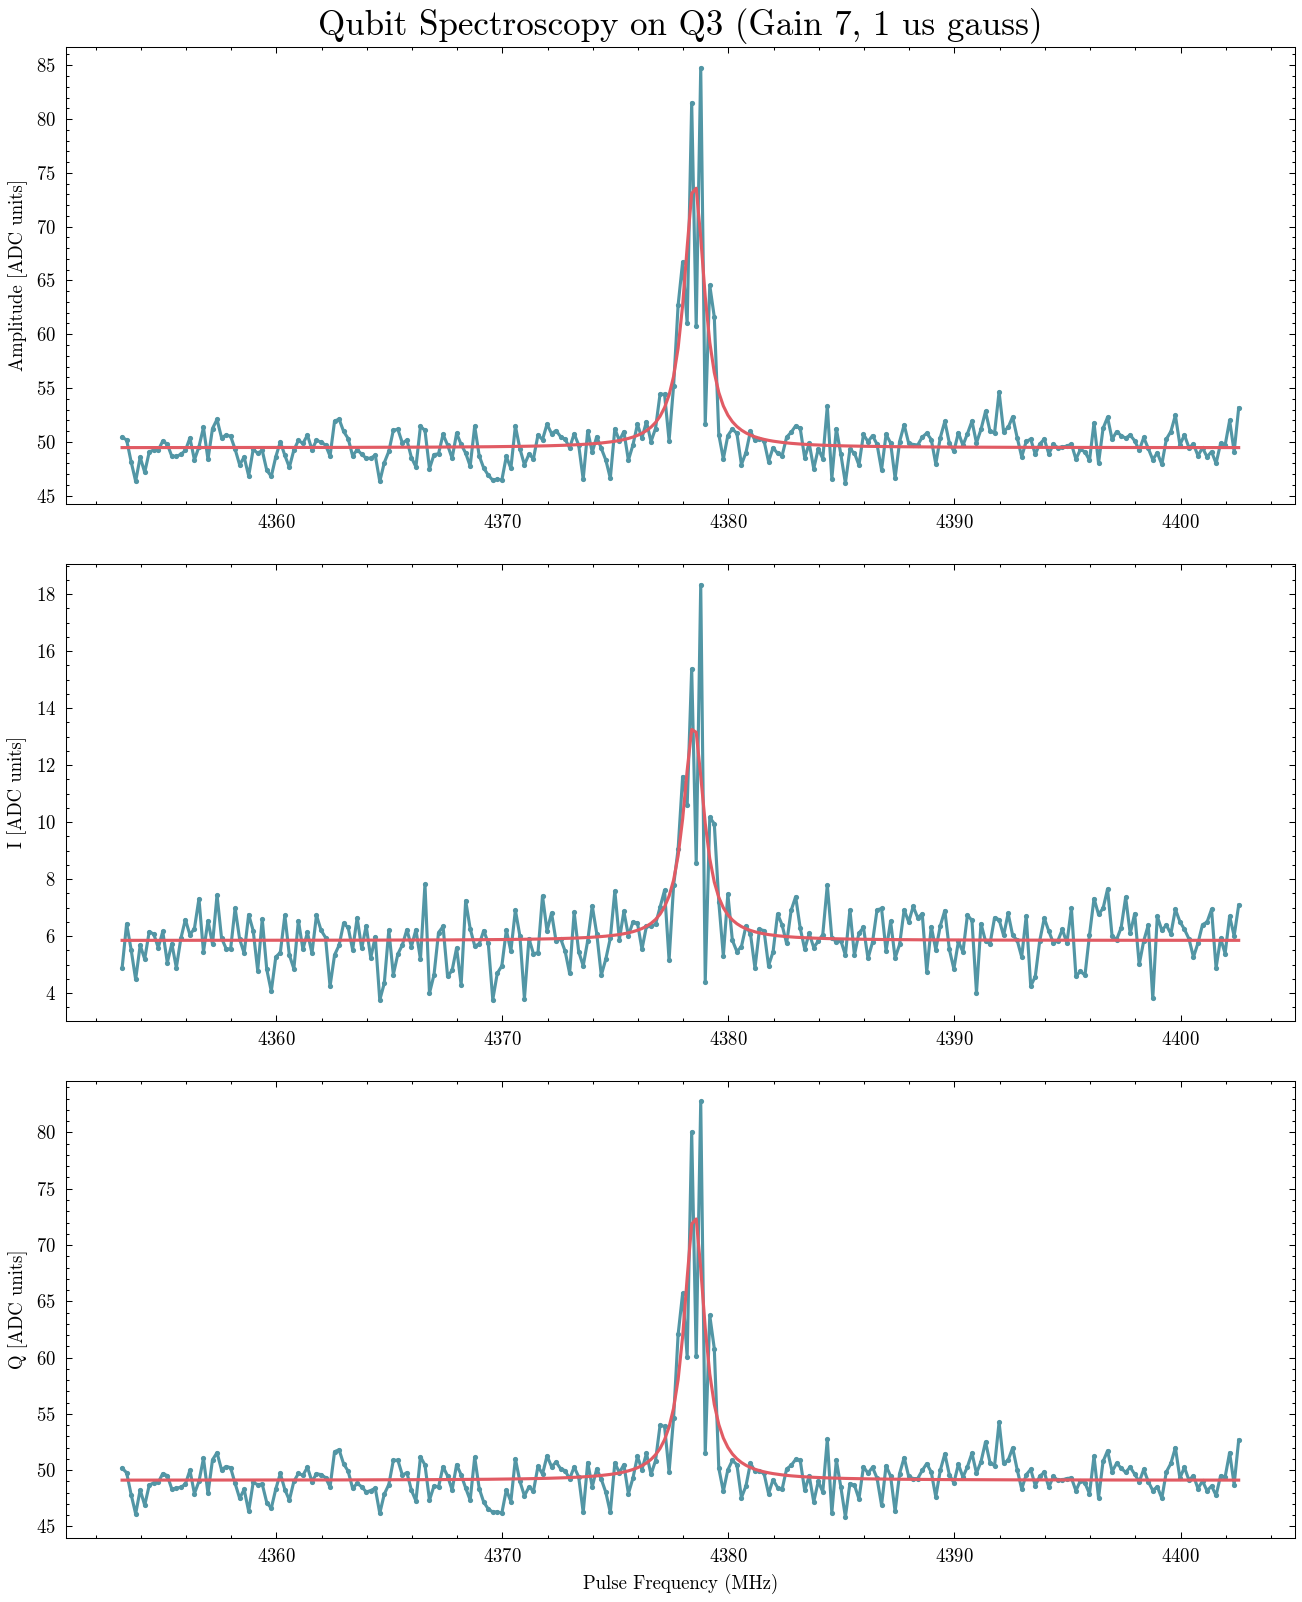

best 2 0.0401233474373249
*Set qubit 3 f_ge to 4378.488236250658*
{'Res freq': 6971.130913013263, 'Res freq (yaml)': -228.86908698673722, 'Res kappa': 0.17872291268329135, 'Qubit freq': 4378.488236250658}


In [72]:
# # TESTING
# # qspec = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_qubit_spectroscopy_qubit0.h5')
# qspec.data = temp_data

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qspec.analyze(fit=True, signs=[1, sign, sign])
        fit_err_i = qspec.data['fit_err_avgi'][2][2]
        fit_err_q = qspec.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[1] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[2] = sign
            best_fit_err_q = fit_err_q
    except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qspec.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qspec.analyze(fit=True, signs=best_signs)
qspec.display(fit=True, signs=best_signs)

qspec_fit, qspec_fit_err = meas.fitting.get_best_fit(qspec.data)
yaml_cfg.device.qubit.f_ge = np.reshape(yaml_cfg.device.qubit.f_ge, (4,4))
yaml_cfg.device.qubit.f_ge[qubit_i, qubit_i] = qspec_fit[2]
print(f'*Set qubit {qubit_i} f_ge to {yaml_cfg.device.qubit.f_ge[qubit_i, qubit_i]}*')
results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i, qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
yaml_cfg.device.qubit.f_ge = yaml_cfg.device.qubit.f_ge.flatten().tolist()
print(results_Qi)

In [24]:
if save_data: saved_files.append(qspec.save_data())

## Pulse Probe (qubit) spectroscopy round 2

In [47]:
qspec2 = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qspec2.cfg = AttrDict(deepcopy(yaml_cfg))

span = 15
npts = 250

qspec2.cfg.expt = dict(
    start=np.reshape(qspec2.cfg.device.qubit.f_ge, (4,4))[qubit_i, qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=reps, # Number of averages per point
    rounds=rounds, # Number of start to finish sweeps to average over
    length=1, # Qubit probe constant pulse length [us]
    gain=int(np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.gain, (4,4))[qubit_i, qubit_i]/80), # Qubit pulse gain
    pulse_type='gauss',
    qTest=qubit_i,
    qZZ=None,
    checkEF=False,
)
qspec2.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]
qspec2.go(analyze=False, display=False, progress=True, save=False)

Running pulse probe on Q2 


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4760.722777872417, HWHM 0.3277327143656634
Found peak in I at [MHz] 4753.929178354025, HWHM 0.006389698086742388
Found peak in Q at [MHz] 4760.722771021318, HWHM 0.3276538550077136


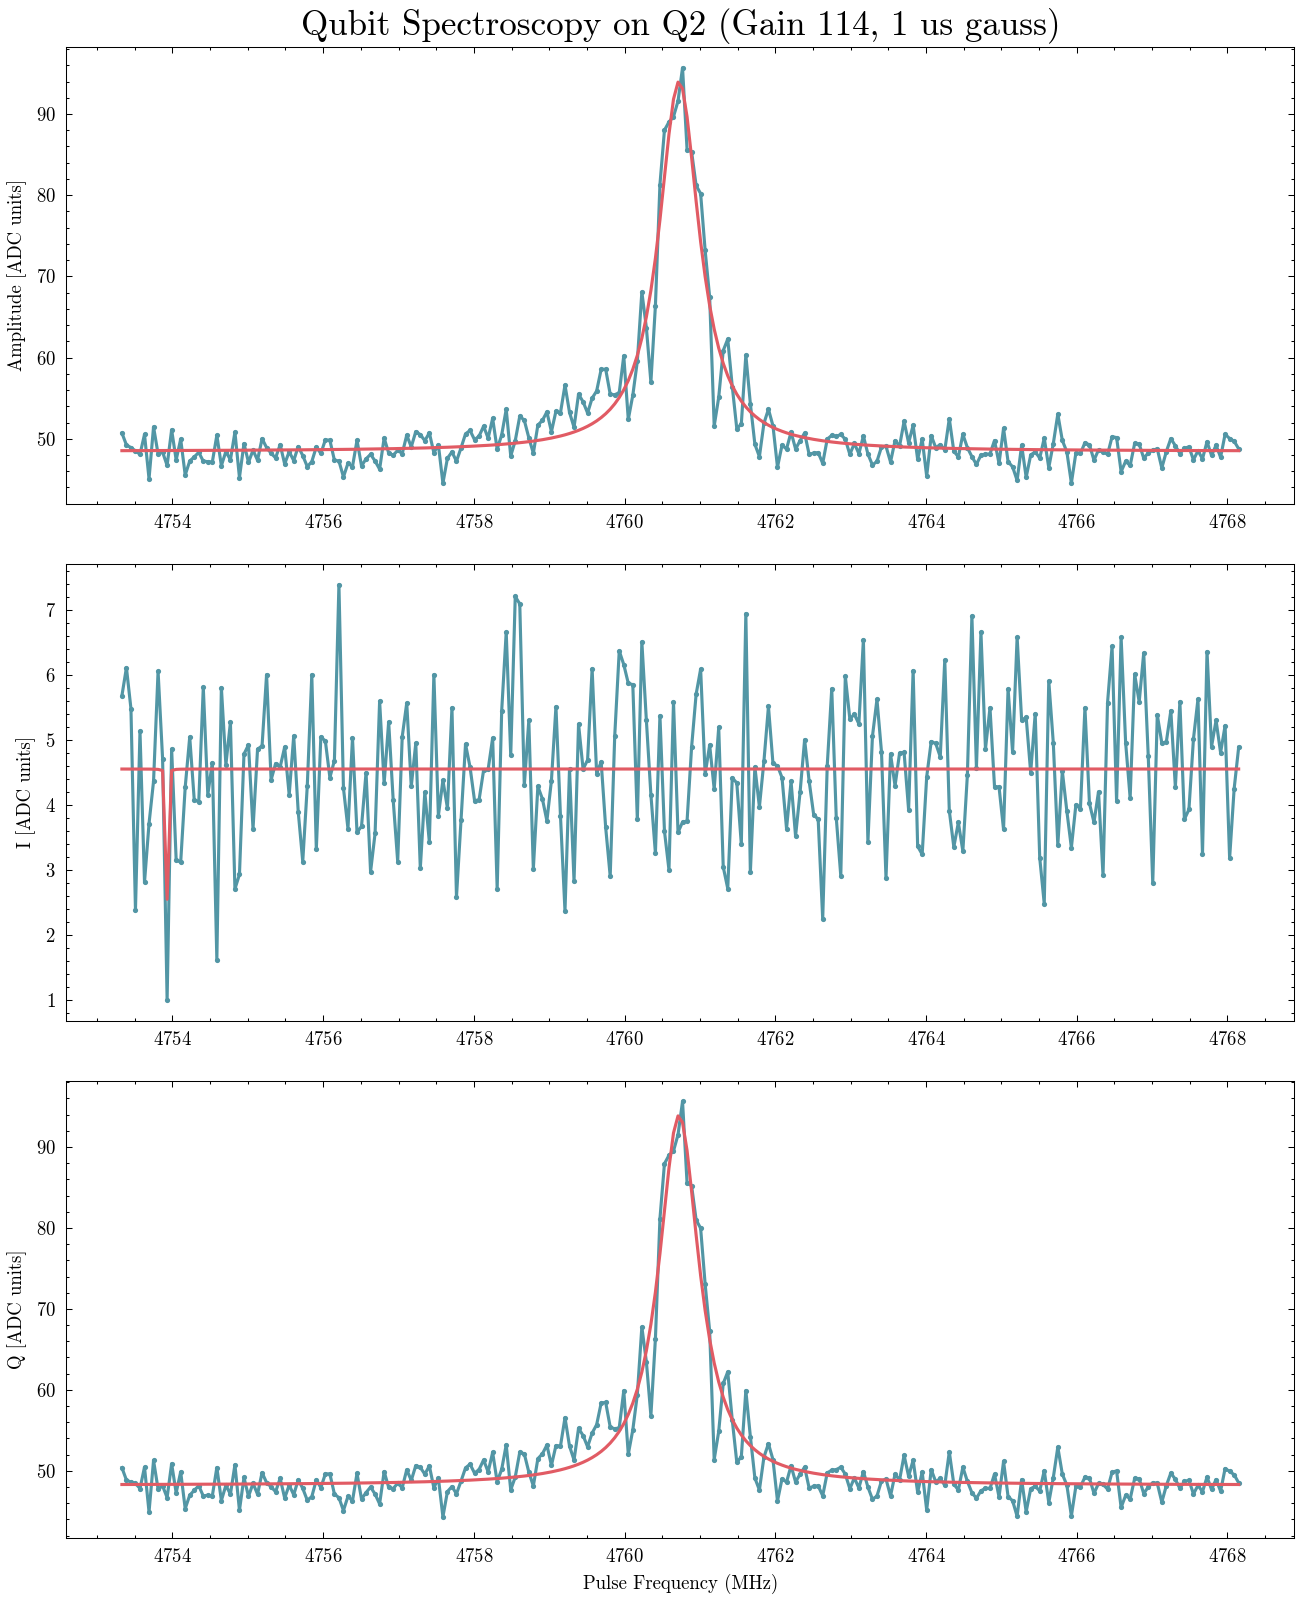

best 2 0.01704097642261019
*Set qubit 2 f_ge to 4760.722771021318*
{'Res freq': 7702.327621781433, 'Res freq (yaml)': 502.32762178143275, 'Res kappa': 0.24292681241212788, 'Qubit freq': 4760.722771021318}


In [48]:
# # TESTING
# # qspec2 = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_qubit_spectroscopy_qubit0.h5')
# qspec2.data = temp_data

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qspec2.analyze(fit=True, signs=[1, sign, sign])
        fit_err_amps = qspec2.data['fit_err_amps'][2][2]
        fit_err_i = qspec2.data['fit_err_avgi'][2][2]
        fit_err_q = qspec2.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[1] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[2] = sign
            best_fit_err_q = fit_err_q
    except: continue
if fit_err_amps == np.inf and best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qspec2.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qspec2.analyze(fit=True, signs=best_signs)
qspec2.display(fit=True, signs=best_signs)

qspec2_fit, qspec2_fit_err = meas.fitting.get_best_fit(qspec2.data)
yaml_cfg.device.qubit.f_ge = np.reshape(yaml_cfg.device.qubit.f_ge, (4,4))
yaml_cfg.device.qubit.f_ge[qubit_i, qubit_i] = qspec2_fit[2]
qubit_hwhm = qspec2_fit[3]
print(f'*Set qubit {qubit_i} f_ge to {yaml_cfg.device.qubit.f_ge[qubit_i, qubit_i]}*')
results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i, qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
yaml_cfg.device.qubit.f_ge = yaml_cfg.device.qubit.f_ge.flatten().tolist()
print(results_Qi)

In [27]:
if save_data: saved_files.append(qspec2.save_data())

## Length Rabi

In [28]:
lengthrabi = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_qubit{qubit_i}",
    config_file=config_path,
)
lengthrabi.cfg = AttrDict(deepcopy(yaml_cfg))

lengthrabi.cfg.expt = dict(
    start=0, # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0.001,
    expts=121,
    reps=reps*rounds,
    pulse_type='gauss',
    checkEF=False, 
    qTest=qubit_i,
    qZZ=None,
)
# lengthrabi.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]
# lengthrabi.pi_ge.gain[4*qubit_i+qubit_i] = 5000 # qubit gain [DAC units],

try:
    lengthrabi.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

Running length rabi on Q3 


  0%|          | 0/121 [00:00<?, ?it/s]

In [29]:
# # TESTING
# # lengthrabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# lengthrabi.data = temp_data

lengthrabi.analyze(fit=True)

lengthrabi_fit, lengthrabi_fit_err = meas.fitting.get_best_fit(lengthrabi.data) #, fitfunc=fitter.decaysin)

lengthrabi.display(fit=True)
# p = lengthrabi_fit
# if p[2] > 180: p[2] = p[2] - 360
# elif p[2] < -180: p[2] = p[2] + 360
# if p[2] < 0: pi_len = (1/2 - p[2]/180)/2/p[1]
# else: pi_len = (3/2 - p[2]/180)/2/p[1]
# pi_len = np.max((0.9*pi_len, 0.015)) # since we run the length rabi at a < max gain

# lengthrabi_decay = p[3]

# print(f'Will use sigma {pi_len} for amplitude rabi')

best 1 0.2230375028289761
Pi length from avgi data [us]: 0.05190566156903359
	Pi/2 length from avgi data [us]: 0.025952830784516795

Pi length from avgq data [us]: 0.04876758588147374
Pi/2 length from avgq data [us]: 0.02438379294073687


In [ ]:
# if save_data: saved_files.append(lengthrabi.save_data())

## Amplitude Rabi

In [18]:
pi_len = np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.sigma, (4,4))[qubit_i, qubit_i]
# pi_len = 0.008
print('qubit', qubit_i, 'pi_len', pi_len)

qubit 2 pi_len 0.015


In [39]:
amprabi = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)
amprabi.cfg = AttrDict(deepcopy(yaml_cfg))

span = min((32000, int(1.5*np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.gain, (4,4))[qubit_i, qubit_i])))
npts = 50

amprabi.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=reps*rounds,
    rounds=1,
    sigma_test=pi_len, # gaussian sigma for pulse length - overrides config [us]
    # sigma_test=0.2,
    checkEF=False, 
    qTest=qubit_i,
    qZZ=None,
    # pulse_type='gauss', 
    pulse_type='robust',

    full_mux_expt=full_mux_expt,
    resonator_reset=resonator_reset,
    use_robust_pulses=use_robust_pulses,
)
amprabi.go(analyze=False, display=False, progress=True, save=False)

Running amp rabi on Q3 
Calibrating robust pulse


  0%|          | 0/50000 [00:00<?, ?it/s]

(4, 50, 1000)


In [40]:
# # TESTING
# # amprabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# amprabi.data = temp_data

# amprabi.display(fit=False)

amprabi.analyze(fit=True)

amprabi_fit, amprabi_fit_err = meas.fitting.get_best_fit(amprabi.data)

p = amprabi_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabi.display(fit=False)
    print(f'WARNING: Fit pi pulse gain is long ({pi_gain}), please double check!')
    pi_gain = 30000
else: amprabi.display(fit=True)
yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i] = amprabi.cfg.expt.sigma_test

print(f'*Set pi pulse sigma for qubit {qubit_i} to {np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.sigma, (4,4))[qubit_i, qubit_i]}*')
yaml_cfg.device.qubit.pulses.pi_ge.gain = np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.gain, (4,4))
yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i, qubit_i] = int(pi_gain)
print(f'*Set pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i, qubit_i]}*')
results_Qi.update({'Pi pulse gain':yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i, qubit_i]})
print(f'*New pi_ge.gain\n', yaml_cfg.device.qubit.pulses.pi_ge.gain)
yaml_cfg.device.qubit.pulses.pi_ge.gain = yaml_cfg.device.qubit.pulses.pi_ge.gain.flatten().astype(int).tolist()
print(f'*New pi_ge.gain flattened\n{yaml_cfg.device.qubit.pulses.pi_ge.gain}')
print(results_Qi)

best 1 0.033312433932937
Pi gain from amps data [dac units]: 23788
	Pi/2 gain from amps data [dac units]: 11894
Pi gain from avgi data [dac units]: 23478
	Pi/2 gain from avgi data [dac units]: 11739
Pi gain from avgq data [dac units]: 23845
	Pi/2 gain from avgq data [dac units]: 11922
*Set pi pulse sigma for qubit 3 to 0.025*
*Set pi pulse gain for qubit 3 to 23478*
*New pi_ge.gain
 [[ 1849  1914     0  1855]
 [ 2834  2504  2648  2631]
 [ 9155  9155  9155  9155]
 [ 3000  3000  3000 23478]]
*New pi_ge.gain flattened
[1849, 1914, 0, 1855, 2834, 2504, 2648, 2631, 9155, 9155, 9155, 9155, 3000, 3000, 3000, 23478]
{'Res freq': 6971.1, 'Res freq (yaml)': -228.9, 'Res kappa': 0.19949934090305999, 'Qubit freq': 4380.01767146236, 'Pi/2 pulse gain': 8820, 'Pi pulse gain': 23478}


In [26]:
if save_data: saved_files.append(amprabi.save_data())

## $T_1$

In [18]:
short_T1 = False
# short_T1 = True

In [19]:
t1 = meas.T1Experiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"t1_qubit{qubit_i}",
    config_file=config_path,
)
t1.cfg = AttrDict(deepcopy(yaml_cfg))

span = 50 if short_T1 else 400
npts = 151

t1.cfg.expt = dict(
    start=0, # wait time [us]
    step=span/npts,
    expts=npts,
    reps=reps,
    # reps=5,
    rounds=rounds,
    qTest=qubit_i,
    qZZ=None,

    full_mux_expt=full_mux_expt,
    resonator_reset=resonator_reset,
    use_robust_pulses=use_robust_pulses,
)
t1.cfg.device.readout.relax_delay = span # Wait time between experiments [us]
t1.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/10 [00:00<?, ?it/s]

 s:\Connie\experiments\qram_tprocv1_expts\experiments\fitting.py: 94

best 2 121052.91846409257
Fit T1 amps [us]: 63.62469052681084
Fit T1 avgi [us]: 50.38332724215895
Fit T1 avgq [us]: 37.83181181969635


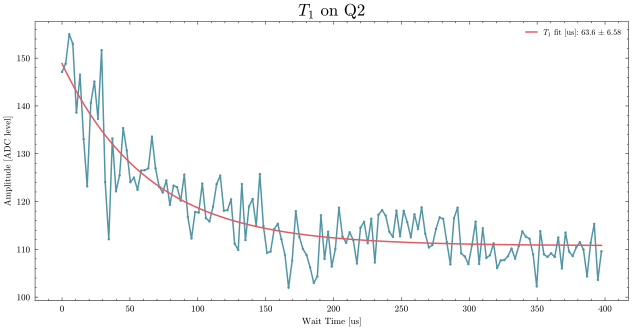

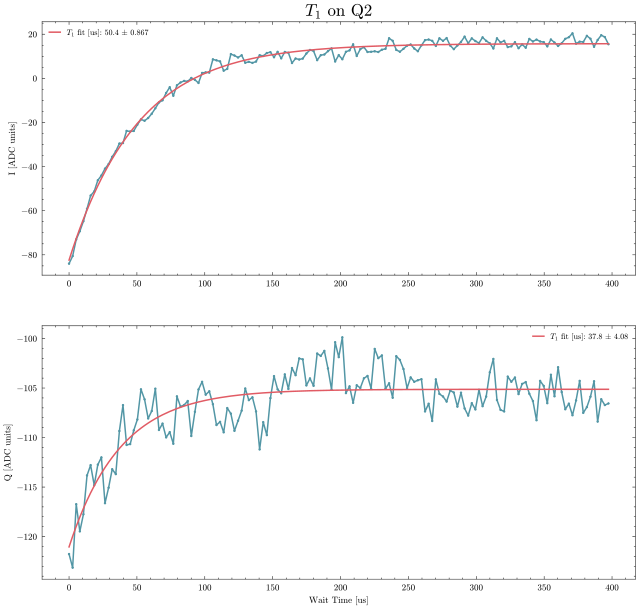

*Set readout 2 relax delay to 151.0*
qubit 2 {'Qubit EF freq': 4573.004729989843, 'T2R EF': 4.597359191321546, 'T2R EF err': 1.0846336294365222, 'T1': 37.83181181969635, 'T1 err': 4.079215698712617}


In [20]:
# # TESTING
# # t1 = meas.T1Experiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_t1_qubit1.h5')
# t1.data = temp_data

t1.analyze(fit_log=False)

t1_fit, t1_fit_err = meas.fitting.get_best_fit(t1.data) #, fitter.expfunc)

t1.display(fit=True, fit_log=False)
t1_qubit = t1_fit[3]
yaml_cfg.device.readout.relax_delay[qubit_i] = np.round(4*t1_qubit)
print(f'*Set readout {qubit_i} relax delay to {yaml_cfg.device.readout.relax_delay[qubit_i]}*')
results_Qi.update({'T1':t1_qubit, 'T1 err':np.sqrt(t1_fit_err[3][3])})
print(f'qubit {qubit_i}', results_Qi)

In [30]:
if save_data: saved_files.append(t1.save_data())

## $T_2$ Ramsey round 1

In [96]:
# yaml_cfg.device.qubit.f_ge[qubit_i] = 145.572034953271
qubit_hwhm = 2
short_T1 = False
# short_T1 = t1_qubit < 20
print('Short T1', short_T1)

Short T1 False


In [97]:
# ramsey_freq = max((min((np.abs(np.ceil(qubit_hwhm)), 3)), 2))
ramsey_freq = 3.0
print(f'Ramsey freq [MHz]: {ramsey_freq}')

Ramsey freq [MHz]: 3.0


In [59]:
t2r = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)
t2r.cfg = AttrDict(deepcopy(yaml_cfg))

# make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
t2r.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(8), # [us] 
    # step=soc.cycles2us(2) if short_T1 else soc.cycles2us(10), # [us] 
    expts=150,
    ramsey_freq=ramsey_freq, # [MHz]
    reps=reps,
    rounds=rounds,
    qTest=qubit_i,
    checkEF=False,
    qZZ=None,
    full_mux_expt=full_mux_expt,
    resonator_reset=resonator_reset,
    use_robust_pulses=use_robust_pulses,
)

try:
    t2r.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

Running Ramsey on Q2 


  0%|          | 0/10 [00:00<?, ?it/s]

best 2 0.022289465803381366
Current pi pulse frequency: 4760.776513809593
Fit frequency from amps [MHz]: 2.724391664846992 +/- 0.005639524775350522
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4761.052122144746
 	4755.052122144746
T2 Ramsey from fit amps [us]: 10.643884215908852 +/- 3.9231839857377975


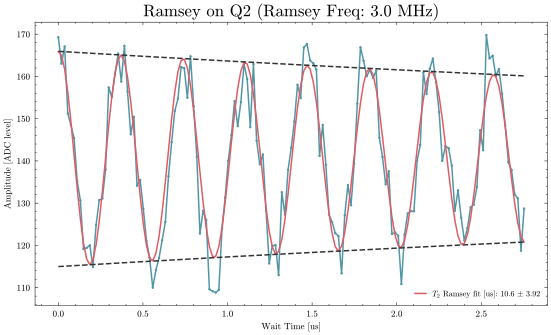

Current pi pulse frequency: 4760.776513809593
Fit frequency from I [MHz]: 2.7319291145152502 +/- 0.014134425342059703
Suggested new pi pulse frequency from fit I [MHz]:
 	4761.044584695078
 	4755.044584695078
T2 Ramsey from fit I [us]: 4.788690861014783 +/- 1.978066860415505
Fit frequency from Q [MHz]: 2.724127339487216 +/- 0.0010544498579592204
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4761.052386470105
 	4755.052386470105
T2 Ramsey from fit Q [us]: 14.131252170820867 +/- 1.2935247205433065


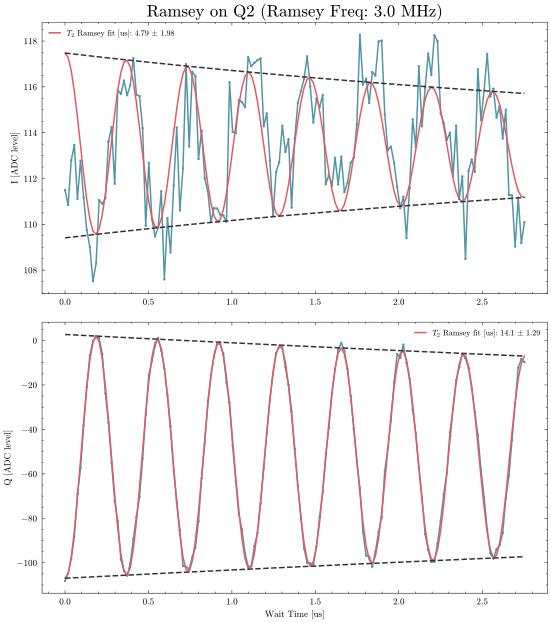

*Set qubit 2 freq to 4761.052386470105*
Alt qubit freq is 4755.052386470105
*New f_ge
 [[4108.79674568 4103.24355302 4108.49168996 4108.0662884 ]
 [3442.86880975 3447.97373604 3447.14985146 3446.94332198]
 [4759.4885898  4758.50698516 4761.05238647 4759.08581649]
 [4377.40782133 4376.65492276 4377.44574713 4378.56886427]]
*New f_ge flattened
[4108.796745676768, 4103.243553024718, 4108.491689964749, 4108.066288400736, 3442.8688097468294, 3447.9737360399195, 3447.149851461427, 3446.943321983037, 4759.488589798401, 4758.50698515513, 4761.052386470105, 4759.085816492836, 4377.407821334912, 4376.654922763285, 4377.445747133665, 4378.56886426902]


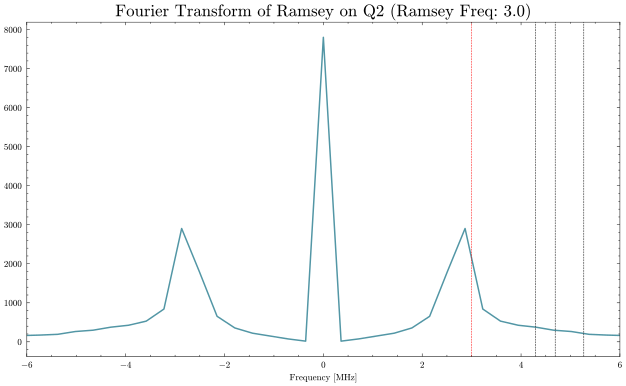

In [60]:
# # TESTING
# # t2r = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2r.data = temp_data

# t2r.analyze(fit=True, fit_num_sin=2)
# t2r.display(fit=True, fit_num_sin=2)

t2r.analyze(fit=True)
t2r_fit, t2r_fit_err, t2r_adjust = meas.fitting.get_best_fit(t2r.data, get_best_data_params=['f_adjust_ramsey'])

old_qubit_freq = np.reshape(t2r.cfg.device.qubit.f_ge, (4,4))[qubit_i, qubit_i]
t2r.display(fit=True)
yaml_cfg.device.qubit.f_ge = np.reshape(yaml_cfg.device.qubit.f_ge, (4,4))
yaml_cfg.device.qubit.f_ge[qubit_i, qubit_i] = old_qubit_freq + t2r_adjust[0]
alt_qubit_freq = old_qubit_freq + t2r_adjust[1]
results_Qi.update({'T2R':t2r_fit[3], 'T2R err':np.sqrt(t2r_fit_err[3][3])})
results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i, qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i, qubit_i]}*')
print(f'Alt qubit freq is {alt_qubit_freq}')

print(f'*New f_ge\n', yaml_cfg.device.qubit.f_ge)
yaml_cfg.device.qubit.f_ge = yaml_cfg.device.qubit.f_ge.flatten().tolist()
print(f'*New f_ge flattened\n{yaml_cfg.device.qubit.f_ge}')

data = t2r.data
fit_axis = 'avgq'
xpts = data['xpts']
fourier = np.fft.fftshift(np.abs(np.fft.fft(data[fit_axis])))
freqs = np.fft.fftshift(np.fft.fftfreq(len(fourier), d=(xpts[1]-xpts[0])))
plt.plot(freqs, fourier)
ZZs = np.zeros((4,4))
reshaped_f_ge = np.reshape(t2r.cfg.device.qubit.f_ge, (4,4))
for row in range(4):
    ZZs[row,:] = reshaped_f_ge[row,:] - reshaped_f_ge[row,row]
for i in range(4):
    if (qubit_i+i)%4 == qubit_i: color = 'r'
    else: color = 'k'
    plt.axvline(t2r.cfg.expt.ramsey_freq - ZZs[qubit_i, (qubit_i+i)%4], color=color, linewidth=0.5, linestyle='--')
plt.xlabel('Frequency [MHz]')
plt.xlim(-6, 6)
# plt.ylim(0, 20000)
plt.title(f'Fourier Transform of Ramsey on Q{qubit_i} (Ramsey Freq: {t2r.cfg.expt.ramsey_freq})')
plt.show()

In [40]:
if save_data: saved_files.append(t2r.save_data())

## Amplitude Rabi round 2

In [24]:
pi_len = np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.sigma, (4,4))[qubit_i, qubit_i]
print('qubit', qubit_i, 'pi_len', pi_len)
# pi_len = 0.025

qubit 0 pi_len 0.02


In [25]:
amprabi_2 = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)
amprabi_2.cfg = AttrDict(deepcopy(yaml_cfg))

n_pulses = 1
span = min((32000, int(1.5*np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.gain, (4,4))[qubit_i, qubit_i])))
npts = 151
    
amprabi_2.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=reps,
    # reps=5,
    rounds=rounds,
    sigma_test=pi_len, # gaussian sigma for pulse length - overrides config [us]
    pulse_type='gauss',
    checkEF=False, 
    n_pulses=n_pulses,
    qTest=qubit_i,
    qZZ=None,
)
amprabi_2.go(analyze=False, display=False, progress=True, save=False)

Running amp rabi on Q0 


  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# # TESTING
# # amprabi_2 = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# amprabi_2.data = temp_data

amprabi_2.analyze(fit=True)

amprabi_2_fit, amprabi_2_fit_err = meas.fitting.get_best_fit(amprabi_2.data)

p = amprabi_2_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabi_2.display(fit=False)
    print(f'WARNING: Fit pi pulse gain is long ({pi_gain}), please double check!')
    pi_gain = 30000
else: amprabi_2.display(fit=True)
yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i] = amprabi_2.cfg.expt.sigma_test

print(f'*Set pi pulse sigma for qubit {qubit_i} to {np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.sigma, (4,4))[qubit_i, qubit_i]}*')
yaml_cfg.device.qubit.pulses.pi_ge.gain = np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.gain, (4,4))
yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i, qubit_i] = int(pi_gain)
print(f'*Set pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i, qubit_i]}*')
results_Qi.update({'Pi pulse gain':yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i, qubit_i]})
print(f'*New pi_ge.gain\n', yaml_cfg.device.qubit.pulses.pi_ge.gain)
yaml_cfg.device.qubit.pulses.pi_ge.gain = yaml_cfg.device.qubit.pulses.pi_ge.gain.flatten().tolist()
print(f'*New pi_ge.gain flattened\n{yaml_cfg.device.qubit.pulses.pi_ge.gain}')
print(results_Qi)

best 0 0.022292039093864034
Pi gain from amps data [dac units]: 935
	Pi/2 gain from amps data [dac units]: 467
Pi gain from avgi data [dac units]: 935
	Pi/2 gain from avgi data [dac units]: 467
Pi gain from avgq data [dac units]: 936
	Pi/2 gain from avgq data [dac units]: 468
*Set pi pulse sigma for qubit 3 to 0.025*
*Set pi pulse gain for qubit 3 to 935*
*New pi_ge.gain
 [[ 1849  1914     0  1855]
 [ 2834  2504  2648  2631]
 [14489 14572 14736 14639]
 [  963   959   974   935]]
*New pi_ge.gain flattened
[1849, 1914, 0, 1855, 2834, 2504, 2648, 2631, 14489, 14572, 14736, 14639, 963, 959, 974, 935]
{'T1': 52.3580045090926, 'T1 err': 1.6646251872930162, 'T2R': 28.080322737694868, 'T2R err': 10.12437756373936, 'Qubit freq': 4381.110012654556, 'Pi pulse gain': 935}


In [38]:
if save_data: saved_files.append(amprabi_2.save_data())

## $T_2$ Ramsey round 2

Check that frequency adjustment helps.

In [98]:
t2r_2 = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)
t2r_2.cfg = AttrDict(deepcopy(yaml_cfg))

# make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
t2r_2.cfg.expt = dict(
    start=0, # wait time tau [us]
    # step=soc.cycles2us(2) if t2r_fit[3] < 3 else soc.cycles2us(60), # [us]
    step=soc.cycles2us(150), # [us]
    expts=151,
    ramsey_freq=ramsey_freq/15, # [MHz]
    reps=reps*rounds*2,
    rounds=1,
    checkEF=False,
    qTest=qubit_i,
    qZZ=None,

    full_mux_expt=full_mux_expt,
    resonator_reset=resonator_reset,
    use_robust_pulses=use_robust_pulses,
)
t2r_2.go(analyze=False, display=False, progress=True, save=False)

Running Ramsey on Q2 


  0%|          | 0/302000 [00:00<?, ?it/s]

best 1 0.03310032915621056
Current pi pulse frequency: 4761.052602755913
Fit frequency from amps [MHz]: 0.21343780306777818 +/- 0.0005051669583461383
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4761.039164952845
 	4760.639164952845
T2 Ramsey from fit amps [us]: 37.375453684728676 +/- 4.323051730945139


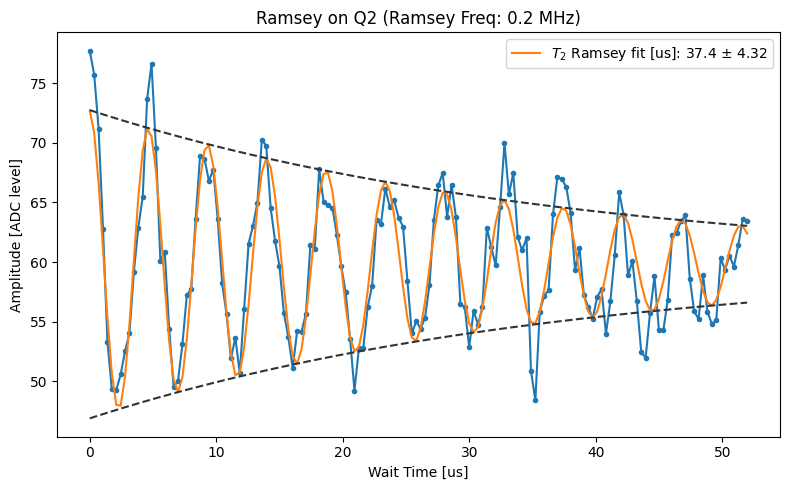

Current pi pulse frequency: 4761.052602755913
Fit frequency from I [MHz]: 0.21336171011078403 +/- 0.0003663037227116126
Suggested new pi pulse frequency from fit I [MHz]:
 	4761.039241045802
 	4760.639241045802
T2 Ramsey from fit I [us]: 38.352032306338714 +/- 3.3057806149267237
Fit frequency from Q [MHz]: 0.21323254193169874 +/- 0.0005057545254113691
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4761.039370213981
 	4760.639370213981
T2 Ramsey from fit Q [us]: 44.08996718851153 +/- 6.055869782595681


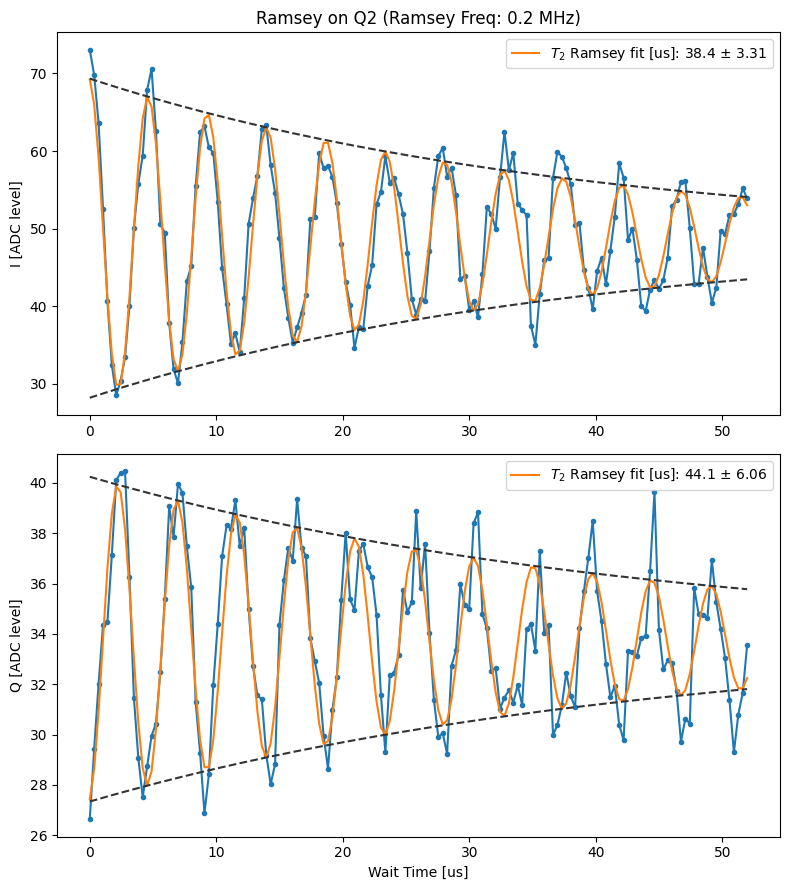

*Set qubit 2 freq to 4761.039241045802*
{'Pi/2 pulse gain': 20280, 'Qubit EF freq': 4572.806811292824, 'T2R EF': 5.407904612166893, 'T2R EF err': 1.36048349442156, 'T2R': 38.352032306338714, 'T2R err': 3.3057806149267237, 'Qubit freq': 4761.039241045802}
*New f_ge
 [[4108.755047   4103.36695408 4108.64937229 4108.23250355]
 [3442.59194135 3447.98151813 3446.87263594 3446.65966586]
 [4760.91183913 4759.94689352 4761.03924105 4760.46101644]
 [4377.99631896 4377.24723967 4377.99576439 4378.45405827]]
*New f_ge flattened
[4108.755047003828, 4103.366954082312, 4108.649372291309, 4108.232503550693, 3442.591941352887, 3447.981518133789, 3446.872635941306, 3446.65966586083, 4760.911839134516, 4759.946893523059, 4761.039241045802, 4760.46101643607, 4377.996318964773, 4377.247239665757, 4377.995764386313, 4378.454058265707]
Redo T2R: False


In [99]:
# TESTING
# t2r_2 = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00004_ramsey_qubit2.h5')
# t2r_2.data = temp_data
# t2r_2.cfg = AttrDict(attrs['config'])

redo_t2r = True

t2r_2.analyze(fit=True)

t2r_2_fit, t2r_2_fit_err, t2r_2_adjust = meas.fitting.get_best_fit(t2r_2.data, get_best_data_params=['f_adjust_ramsey'])

t2r_2.display(fit=True)
old_qubit_freq = np.reshape(t2r_2.cfg.device.qubit.f_ge, (4,4))[qubit_i, qubit_i]
if abs(t2r_2_adjust[0]) <= ramsey_freq/10:
# if abs(t2r_2_adjust[0]) <= abs(t2r_2_adjust[0]):
    redo_t2r = False
    yaml_cfg.device.qubit.f_ge = np.reshape(yaml_cfg.device.qubit.f_ge, (4,4))
    yaml_cfg.device.qubit.f_ge[qubit_i, qubit_i] = old_qubit_freq + t2r_2_adjust[0]
    results_Qi.update({'T2R':t2r_2_fit[3], 'T2R err':np.sqrt(t2r_2_fit_err[3][3])})
    results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i, qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
    print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i, qubit_i]}*')
    print(results_Qi)
    print(f'*New f_ge\n', yaml_cfg.device.qubit.f_ge)
    yaml_cfg.device.qubit.f_ge = yaml_cfg.device.qubit.f_ge.flatten().tolist()
    print(f'*New f_ge flattened\n{yaml_cfg.device.qubit.f_ge}')

else: # redo_t2r = True
    yaml_cfg.device.qubit.f_ge[qubit_i] = alt_qubit_freq 
    print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
print(f'Redo T2R: {redo_t2r}')

In [43]:
if save_data: saved_files.append(t2r_2.save_data())

## $\pi$, -$\pi$ experiment

In [130]:
use_robust_pulses = True

In [ ]:
piminuspi = meas.PiMinusPiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"PiMinusPiExpt{qubit_i}",
    config_file=config_path,
)

piminuspi.cfg = AttrDict(deepcopy(yaml_cfg))

span_f = 2.0
# npts_f = 50
npts_f = 30

if not use_robust_pulses:
    start_f = piminuspi.cfg.device.qubit.f_ge[qubit_i*4 + qubit_i]-span_f/2
    pulse_type = "gauss"
else:
    start_f=piminuspi.cfg.device.qubit.f_ge_robust[qubit_i*4 + qubit_i]-span_f/2,
    pulse_type = "robust"

piminuspi.cfg.expt = dict(
    start_N=0, # number gate repetitions
    step_N=4,
    expts_N=10,
    start_f=start_f,
    step_f=span_f/npts_f,
    expts_f=npts_f+1,
    reps=int(0.75*reps*rounds),
    # reps=10,
    loops=1,
    pulse_type=pulse_type,
    use_robust_pulses=use_robust_pulses,

    checkEF=False,
    qTest=qubit_i,
    qZZ=None,

    test_pi_half=False,

    post_process='threshold',
    singleshot_reps=15000,
)

# print(piminuspi.cfg)
import Pyro4.util
try:
    piminuspi.acquire(progress=True, debug=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 78.30666666666667 	 angle (deg): -96.83569591568404 	 threshold ge: 398.7212265605594


  0%|          | 0/10 [00:00<?, ?it/s]

In [132]:
# # TESTING
# temp_data, attrs = prev_data('s:\Connie\experiments\qramLL_4QR2\data\data_240617\\00000_PiMinusPiExpt0.h5')
# piminuspi.data =  temp_data
# piminuspi.cfg = AttrDict(attrs['config'])


data = piminuspi.data
piminuspi.analyze(fit=True)
piminuspi.display(fit=True)

if not use_robust_pulses:
    freq_update = "f_ge"
else:
    freq_update = "f_ge_robust"
yaml_cfg.device.qubit[freq_update] = np.reshape(yaml_cfg.device.qubit[freq_update], (4,4))
yaml_cfg.device.qubit[freq_update][qubit_i, qubit_i] = data["best_freq"]
results_Qi.update({'Qubit freq':yaml_cfg.device.qubit[freq_update][qubit_i, qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit[freq_update][qubit_i, qubit_i]}*')
print(results_Qi)
print(f'*New {freq_update}\n', yaml_cfg.device.qubit[freq_update])
yaml_cfg.device.qubit[freq_update] = yaml_cfg.device.qubit[freq_update].flatten().tolist()
print(f'*New {freq_update} flattened\n{yaml_cfg.device.qubit[freq_update]}')

Fit best freq 4111.8334058569635 which is -0.47307206386085454 away from old freq 4112.306477920824
*Set qubit 0 freq to 4111.8334058569635*
{'T1': 64.05955000251987, 'T1 err': 1.119240285515182, 'T2R': 18.248886781332068, 'T2R err': 0.7816516069106116, 'Qubit freq': 4111.8334058569635, 'T2E': 56.36959417286505, 'T2E err': 1.4283912853884384, 'Res freq': 6810.011666666666, 'Res freq (yaml)': -389.98833333333334, 'Res kappa': 0.2735895597906132, 'Res chi shift (e - g)': -0.8642384105960446, 'Pi/2 pulse gain': 7569}
*New f_ge_robust
 [[4111.83340586 4112.30647792 4112.30647792 4112.30647792]
 [3450.05408931 3450.05408931 3450.05408931 3450.05408931]
 [4763.941      4763.941      4763.941      4763.941     ]
 [4384.25034226 4384.25034226 4384.25034226 4384.25034226]]
*New f_ge_robust flattened
[4111.8334058569635, 4112.306477920824, 4112.306477920824, 4112.306477920824, 3450.0540893078382, 3450.0540893078382, 3450.0540893078382, 3450.0540893078382, 4763.941, 4763.941, 4763.941, 4763.941, 

In [ ]:
if save_data: piminuspi.save_data()

## GE error amplification

In [ ]:
npulsecalib = meas.NPulseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"NPulseExptQ{qubit_i}",
    config_file=config_path,
)

npulsecalib.cfg = AttrDict(deepcopy(yaml_cfg))
npulsecalib.cfg.expt = dict(
    start=0, # number gate repetitions
    step=1,
    expts=10,
    reps=1000,
    loops=20,
    pulse_type='gauss',
    checkEF=False, 
    qTest=qubit_i,
    qZZ=None,
    test_pi_half=False,
    error_amp=True,

    post_process='scale',
    singleshot_reps=15000,
)

# print(npulsecalib.cfg)
import Pyro4.util
try:
    npulsecalib.acquire(progress=True, debug=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabi.analyze(data=temp_data, fit=True)

data = npulsecalib.data
npulsecalib.analyze(fit=True, scale=None)
npulsecalib.display(fit=True, scale=None)

# npulsecalib_fit, npulsecalib_fit_err = meas.fitting.get_best_fit(npulsecalib.data)
fit_axis = 'avgi'
npulsecalib_fit = data['fit_avgi']
npulsecalib_fit_err = data['fit_err_avgi']

angle_err = npulsecalib_fit[1]
amp_ratio = (180 - angle_err) / 180
new_amp_ge = np.reshape(npulsecalib.cfg.device.qubit.pulses.pi_ge.gain, (4,4))[qubit_i, qubit_i] / amp_ratio

yaml_cfg.device.qubit.pulses.pi_ge.gain = np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.gain, (4,4))
yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i, qubit_i] = int(round(new_amp_ge))
print(f'*Set pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i, qubit_i]}*')
results_Qi.update({'Pi pulse gain':yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i, qubit_i]})
print(f'*New pi_ge.gain\n', yaml_cfg.device.qubit.pulses.pi_ge.gain)
yaml_cfg.device.qubit.pulses.pi_ge.gain = yaml_cfg.device.qubit.pulses.pi_ge.gain.flatten().tolist()
print(f'*New pi_ge.gain flattened\n{yaml_cfg.device.qubit.pulses.pi_ge.gain}')
print(results_Qi)

In [ ]:
if save_data: npulsecalib.save_data()

## $T_2$ Echo

In [139]:
# yaml_cfg.device.qubit.f_ge[qubit_i] = 145.572034953271
qubit_hwhm = 2
short_T1 = False
# short_T1 = True
# short_T1 = yaml_cfg.device.qubit.T1[qubit_i] < 20
print('Short T1', short_T1)

Short T1 False


In [140]:
ramsey_freq = max((min((np.abs(np.ceil(qubit_hwhm)), 3)), 2))
# ramsey_freq = 1
print(f'Ramsey freq [MHz]: {ramsey_freq}')

Ramsey freq [MHz]: 2.0


In [164]:
t2e = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"echo_qubit{qubit_i}",
    config_file=config_path,
)
t2e.cfg = AttrDict(deepcopy(yaml_cfg))

t2e.cfg.expt = dict(
    start=0, # total wait time b/w the two pi/2 pulses [us]
    # step=soc.cycles2us(80), # make sure nyquist freq = 0.5*(1/step) > ramsey (signal) freq!
    # step=soc.cycles2us(30) if short_T1 else soc.cycles2us(150), # [us] 
    step=soc.cycles2us(10),
    expts=151,
    # ramsey_freq=max((ramsey_freq/15, 0.100)), # frequency by which to advance phase [MHz]
    ramsey_freq=ramsey_freq,
    # ramsey_freq=ramsey_freq, # frequency by which to advance phase [MHz]
    num_pi=1, # number of pi pulses
    echo_type='cpmg', # cp or cpmg
    reps=reps,
    # reps=10,
    rounds=rounds,
    qTest=qubit_i,
    qZZ=None,
    checkEF=False,

    full_mux_expt=full_mux_expt,
    resonator_reset=resonator_reset,
    use_robust_pulses=use_robust_pulses,
)
t2e.go(analyze=False, display=False, progress=True, save=False)

Running Ramsey Echo on Q2 


  0%|          | 0/10 [00:00<?, ?it/s]

Qubit 2
best 2 0.10484714231982792
Current pi pulse frequency: 4756.287914870161
Fit frequency from amps [MHz]: 3.062616043043896 +/- 0.054102411503156554
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4756.2252988271175
 	4750.2252988271175
T2 Ramsey from fit amps [us]: 1.039341517857143 +/- 0.3838661771646575


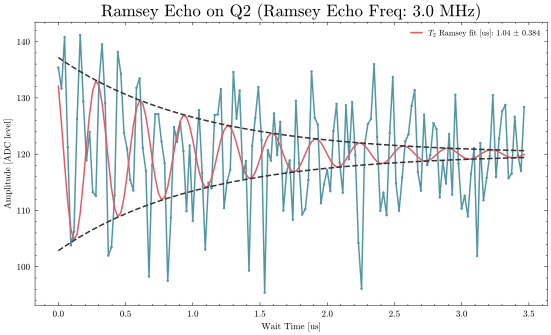

Current pi pulse frequency: 4756.287914870161
Fit frequency from I [MHz]: 2.9383696414800693 +/- 0.040954621411475566
Suggested new pi pulse frequency from fit I [MHz]:
 	4756.349545228682
 	4750.349545228682
T2 Ramsey from fit I [us]: 1.039341517857143 +/- 0.29104328528202794
Fit frequency from Q [MHz]: 2.9925144452921275 +/- 0.03755855727041359
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4756.2954004248695
 	4750.2954004248695
T2 Ramsey from fit Q [us]: 1.039341517857143 +/- 0.2557541816250451


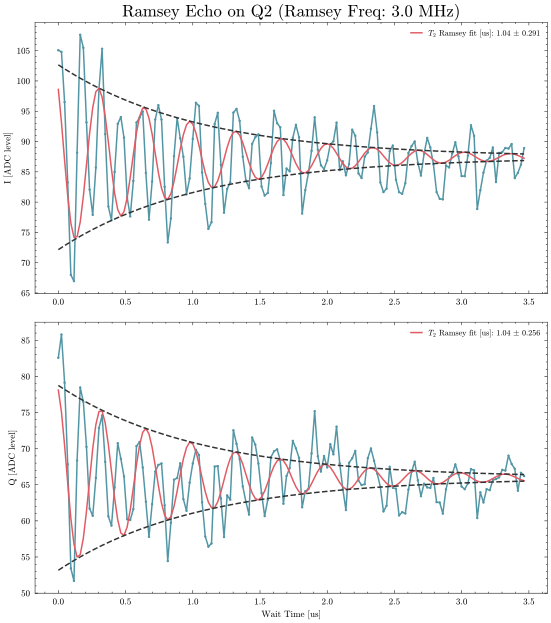

{'T2R EF': 0.8314732142857144, 'T2R EF err': 0.11549229369494339, 'Qubit EF freq': 4576.087703587316, 'Pi EF pulse gain': 11115, 'Pi/2 EF pulse gain': 7104, 'T2E': 1.039341517857143, 'T2E err': 0.2557541816250451, 'Qubit freq': 4756.287914870161, 'T2R': 1.1049107142857144, 'T2R err': 0.19472150064861896, 'Pi/2 pulse gain': 21384, 'Res freq': 7702.354288448099, 'Res freq (yaml)': 502.3542884480994, 'Res kappa': 0.2497514498894884}


In [165]:
# # TESTING
# # t2e = meas.RamseyEchoExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_echo_qubit1.h5')
# t2e.data = temp_data

print(f'Qubit {qubit_i}')
t2e.analyze(fit=True)

t2e_fit, t2e_fit_err = meas.fitting.get_best_fit(t2e.data)

if not isinstance(t2e_fit, (list, np.ndarray)):
    t2e.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

t2e.display(fit=True)
results_Qi.update({'T2E':t2e_fit[3], 'T2E err':np.sqrt(t2e_fit_err[3][3])})
print(results_Qi)
# print('Results updated.')

In [46]:
if save_data: saved_files.append(t2e.save_data())

## (Divide len) Calibrate $\pi/2$ pulse

### Amplitude rabi for $\pi/2$ pulse (divide len) (use this for protocol)

In [81]:
divide_len = True

In [82]:
pi_len = np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.sigma, (4,4))[qubit_i, qubit_i]
# pi_len = 0.008
print('qubit', qubit_i, 'pi_len', pi_len)

qubit 2 pi_len 0.015


In [83]:
amprabi_3 = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)
amprabi_3.cfg = AttrDict(deepcopy(yaml_cfg))

span = min((32000, int(1.5*np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.gain, (4,4))[qubit_i, qubit_i])))
if use_robust_pulses:
    span = min((32000, int(1.5*np.reshape(yaml_cfg.device.qubit.pulses.pihalf_ge_robust.gain, (4,4))[qubit_i, qubit_i])))
npts = 50
    
amprabi_3.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=reps*rounds,
    rounds=1,
    sigma_test=pi_len, # gaussian sigma for pulse length - overrides config [us]
    pulse_type="gauss" if not use_robust_pulses else "robust",
    checkEF=False, 
    n_pulses=1,
    test_pi_half=True,
    qTest=qubit_i,
    qZZ=None,

    use_robust_pulses=use_robust_pulses,
)
amprabi_3.go(analyze=False, display=False, progress=True, save=False)

Running amp rabi on Q2 
Calibrating robust pulse


  0%|          | 0/50000 [00:00<?, ?it/s]

(4, 50, 1000)


best 2 0.018194864910026563
Pi gain from amps data [dac units]: 20166
	Pi/2 gain from amps data [dac units]: 10083
Pi gain from avgi data [dac units]: 20132
	Pi/2 gain from avgi data [dac units]: 10066
Pi gain from avgq data [dac units]: 20280
	Pi/2 gain from avgq data [dac units]: 10140


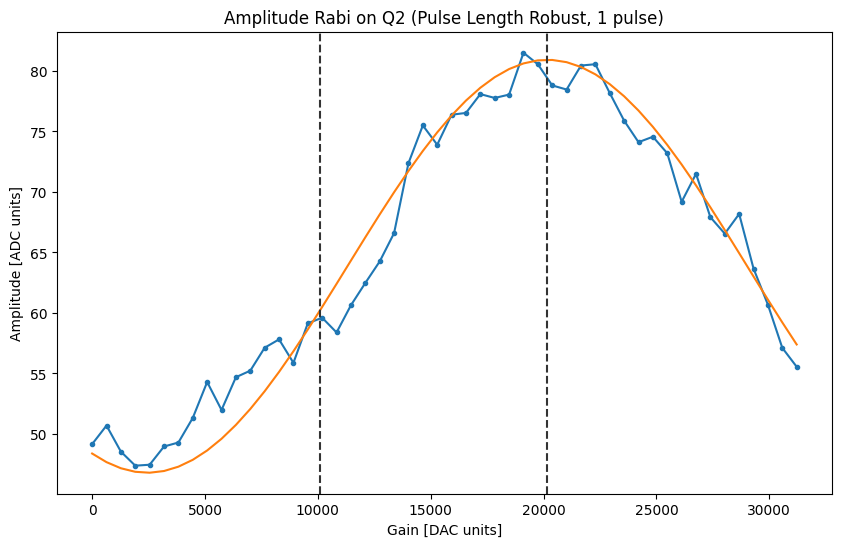

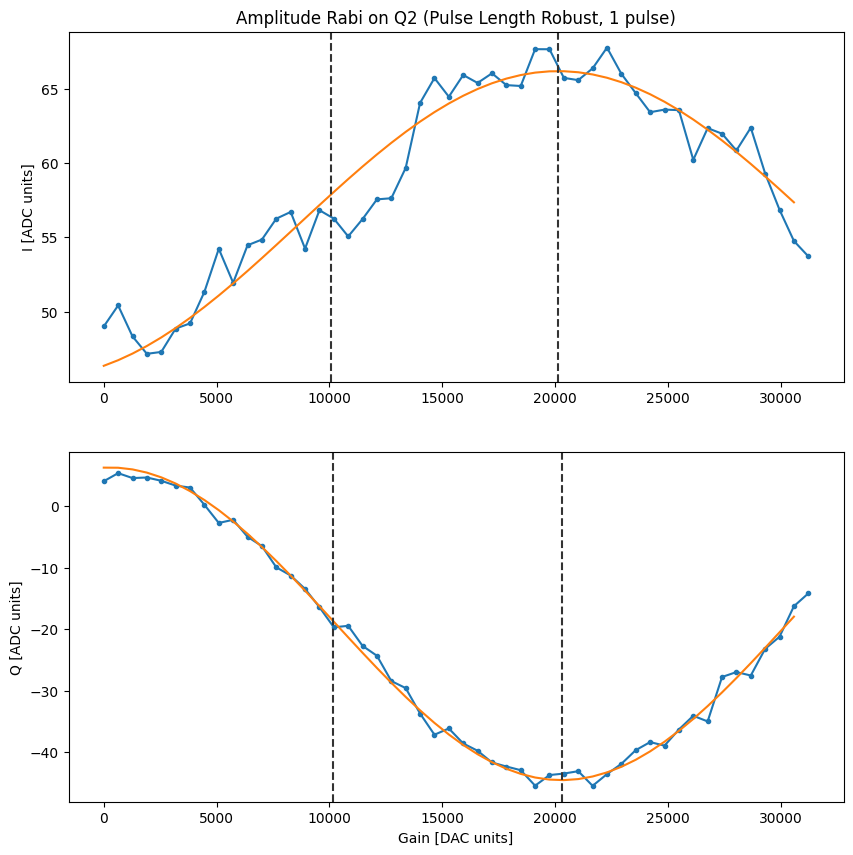

*Set pi/2 pulse gain for qubit 2 to 20280*
*New pihalf_ge_robust.gain
 [[ 7450  7598  7491  7508]
 [ 4874  4433  4502  4462]
 [21240 21296 20280 21315]
 [12113 12006 12134 11998]]
*New pihalf_ge_robust.gain flattened
[7450, 7598, 7491, 7508, 4874, 4433, 4502, 4462, 21240, 21296, 20280, 21315, 12113, 12006, 12134, 11998]
{'Pi/2 pulse gain': 20280}


In [87]:
# # TESTING
# # amprabi_3 = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# amprabi_3.data = temp_data

# amprabi_3.display(fit=False)

amprabi_3.analyze(fit=True)

amprabi_3_fit, amprabi_3_fit_err = meas.fitting.get_best_fit(amprabi_3.data)

p = amprabi_3_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabi_3.display(fit=False)
    print(f'WARNING: Fit pi/2 pulse gain is long ({pi_gain}), please double check!')
    pi_gain = 30000
else: amprabi_3.display(fit=True)

if use_robust_pulses:
    pulse_name = "pihalf_ge_robust"
    gain_name = "gain"
else:
    pulse_name = "pi_ge"
    gain_name = "half_gain"
yaml_cfg.device.qubit.pulses[pulse_name][gain_name] = np.reshape(yaml_cfg.device.qubit.pulses[pulse_name][gain_name], (4,4))
yaml_cfg.device.qubit.pulses[pulse_name][gain_name][qubit_i, qubit_i] = int(pi_gain)
print(f'*Set pi/2 pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses[pulse_name][gain_name][qubit_i, qubit_i]}*')
results_Qi.update({'Pi/2 pulse gain':yaml_cfg.device.qubit.pulses[pulse_name][gain_name][qubit_i, qubit_i]})
print(f'*New {pulse_name}.{gain_name}\n', yaml_cfg.device.qubit.pulses[pulse_name][gain_name])
yaml_cfg.device.qubit.pulses[pulse_name][gain_name] = yaml_cfg.device.qubit.pulses[pulse_name][gain_name].flatten().astype(int).tolist()
print(f'*New {pulse_name}.{gain_name} flattened\n{yaml_cfg.device.qubit.pulses[pulse_name][gain_name]}')
print(results_Qi)

In [ ]:
if save_data: saved_files.append(amprabi_3.save_data())

### $\pi/2$, -$\pi/2$ experiment

In [113]:
use_robust_pulses = False

In [21]:
sweep_phase = True

In [40]:
piminuspi = meas.PiMinusPiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"PiMinusPiExpt{qubit_i}",
    config_file=config_path,
)

piminuspi.cfg = AttrDict(deepcopy(yaml_cfg))

span_f = 5.0
npts_f = 30
# span_f = 2.0
# npts_f = 10

# span_f = 0.0
# npts_f = 1

start_f = piminuspi.cfg.device.qubit.f_ge[qubit_i*4 + qubit_i]-span_f/2
pulse_type = "gauss"
if use_robust_pulses:
    pulse_type = "robust"
    if not sweep_phase:
        start_f = piminuspi.cfg.device.qubit.f_ge_robust[qubit_i*4 + qubit_i]-span_f/2,
    else:
        start_f = -span_f/2

piminuspi.cfg.expt = dict(
    start_N=0, # number gate repetitions
    step_N=1,
    expts_N=10,
    # step_N=4,
    # expts_N=4,
    start_f=start_f,
    step_f=span_f/npts_f,
    expts_f=npts_f+1,
    # reps=int(0.75*reps*rounds),
    # reps=1000,
    reps=500,
    # reps=10,
    loops=1,
    pulse_type=pulse_type,
    use_robust_pulses=use_robust_pulses,

    checkEF=False,
    qTest=qubit_i,
    qZZ=None,

    # use_Y=True,

    test_pi_half=True,

    post_process='threshold',
    singleshot_reps=15000,

    sweep_phase=sweep_phase,

    full_mux_expt=full_mux_expt,
    resonator_reset=resonator_reset,
)

# print(piminuspi.cfg)
import Pyro4.util
try:
    piminuspi.acquire(progress=True, debug=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 66.23234437851413 	 angle (deg): -26.387257959233988 	 threshold ge: 52.10000869145318


  0%|          | 0/10 [00:00<?, ?it/s]

In [41]:
# # TESTING
# temp_data, attrs = prev_data('s:\Connie\experiments\qramLL_4QR2\data\data_240617\\00000_PiMinusPiExpt0.h5')
# piminuspi.data =  temp_data
# piminuspi.cfg = AttrDict(attrs['config'])


data = piminuspi.data
piminuspi.analyze(fit=True)
piminuspi.display(fit=True)

if not sweep_phase:
    if not use_robust_pulses:
        freq_update = "f_ge"
    else:
        freq_update = "f_ge_robust"
    yaml_cfg.device.qubit[freq_update] = np.reshape(yaml_cfg.device.qubit[freq_update], (4,4))
    yaml_cfg.device.qubit[freq_update][qubit_i, qubit_i] = data["best_freq"]
    results_Qi.update({'Qubit freq':yaml_cfg.device.qubit[freq_update][qubit_i, qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
    print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit[freq_update][qubit_i, qubit_i]}*')
    print(results_Qi)
    print(f'*New {freq_update}\n', yaml_cfg.device.qubit[freq_update])
    yaml_cfg.device.qubit[freq_update] = yaml_cfg.device.qubit[freq_update].flatten().tolist()
    print(f'*New {freq_update} flattened\n{yaml_cfg.device.qubit[freq_update]}')

else:
    if not use_robust_pulses:
        yaml_cfg.device.qubit.pulses.pi_ge.half_correction_phase[qubit_i*4 + qubit_i] = data["best_phase"]
        print(f'*New pi_ge.half_correction_phase \n{yaml_cfg.device.qubit.pulses.pi_ge.half_correction_phase}')
    else:
        yaml_cfg.device.qubit.pulses.pihalf_ge_robust.correction_phase[qubit_i*4 + qubit_i] = data["best_phase"]
        print(f'*New pihalf_ge_robust.correction_phase \n{yaml_cfg.device.qubit.pulses.pihalf_ge_robust.correction_phase}')

Fit best freq 1.6904291867323187 which is 1.6904291867323187 away from old freq 0
Best virtual Z (deg) 15.21386268059087
*New pihalf_ge_robust.correction_phase 
[12.831628835545475, 10.05593135477756, 0, 0, 0.11174784781734694, -0.41895542828054083, 0, 0, 0, 0, 2.9582000054694726, 0, 0, 0, 0, 15.21386268059087]


In [ ]:
if save_data: piminuspi.save_data()

### GE $\pi/2$ error amplification (divide len)

In [196]:
divide_len = True

In [197]:
npulsecalib_gehalf = meas.NPulseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"NPulseExptQ{qubit_i}",
    config_file=config_path,
)

if not use_robust_pulses:
    pulse_type = "gauss"
else:
    pulse_type = "robust"

npulsecalib_gehalf.cfg = AttrDict(deepcopy(yaml_cfg))
npulsecalib_gehalf.cfg.expt = dict(
    start=0, # number gate repetitions
    step=1,
    expts=20,
    reps=1000,
    loops=20,
    pulse_type=pulse_type,
    test_pi_half=True,
    divide_len=divide_len,
    error_amp=True,
    use_robust_pulses=use_robust_pulses,
    use_Y=False,

    checkEF=False,
    qTest=qubit_i,
    qZZ=None,

    post_process='scale',
    singleshot_reps=15000,
)

# print(npulsecalib_gehalf.cfg)
try:
    npulsecalib_gehalf.acquire(progress=True, debug=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 81.28 	 angle (deg): 34.05335509852408 	 threshold ge: -666.1487237776781


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qram_tprocv1_expts\experiments\clifford_averager_program.py: 1742

In [202]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabi.analyze(data=temp_data, fit=True)

data = npulsecalib_gehalf.data
npulsecalib_gehalf.analyze(fit=True, scale=None)
npulsecalib_gehalf.display(fit=True, scale=None)

# npulsecalib_gehalf_fit, npulsecalib_gehalf_fit_err = meas.fitting.get_best_fit(npulsecalib_gehalf.data)
fit_axis = 'avgi'
npulsecalib_gehalf_fit = data['fit_avgi']
npulsecalib_gehalf_fit_err = data['fit_err_avgi']

angle_err = npulsecalib_gehalf_fit[1]
amp_ratio = (90 - angle_err)/90
new_amp_half_ge = npulsecalib_gehalf.cfg.expt.gain / amp_ratio

pi_gain = int(round(new_amp_half_ge))

if use_robust_pulses:
    pulse_name = "pihalf_ge_robust"
    gain_name = "gain"
else:
    pulse_name = "pi_ge"
    gain_name = "half_gain"
yaml_cfg.device.qubit.pulses[pulse_name][gain_name] = np.reshape(yaml_cfg.device.qubit.pulses[pulse_name][gain_name], (4,4))
yaml_cfg.device.qubit.pulses[pulse_name][gain_name][qubit_i, qubit_i] = int(pi_gain)
print(f'*Set pi/2 pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses[pulse_name][gain_name][qubit_i, qubit_i]}*')
results_Qi.update({'Pi/2 pulse gain':yaml_cfg.device.qubit.pulses[pulse_name][gain_name][qubit_i, qubit_i]})
print(f'*New {pulse_name}.{gain_name}\n', yaml_cfg.device.qubit.pulses[pulse_name][gain_name])
yaml_cfg.device.qubit.pulses[pulse_name][gain_name] = yaml_cfg.device.qubit.pulses[pulse_name][gain_name].flatten().astype(int).tolist()
print(f'*New {pulse_name}.{gain_name} flattened\n{yaml_cfg.device.qubit.pulses[pulse_name][gain_name]}')
print(results_Qi)

fitparams [None, 0.017453292519943295]
From amps: adjust amplitude to 3595 / 1.0526538911009298 = 3415.1776100310894
From avgi: adjust amplitude to 3595 / 1.004050416624822 = 3580.4974934274874
From avgq: adjust amplitude to 3595 / 0.947346260195975 = 3794.8109904991993
*Set pi/2 pulse gain for qubit 3 to 3580*
*New pihalf_ge_robust.gain
 [[ 7569  7569  7569  7569]
 [ 4982  4982  4982  4982]
 [31856 31856 31856 31856]
 [ 3595  3595  3595  3580]]
*New pihalf_ge_robust.gain flattened
[7569, 7569, 7569, 7569, 4982, 4982, 4982, 4982, 31856, 31856, 31856, 31856, 3595, 3595, 3595, 3580]
{'Res freq': 6971.126666666667, 'Res freq (yaml)': -228.87333333333333, 'Res kappa': 0.21493746441942563, 'Res chi shift (e - g)': -0.8046357615893953, 'Qubit freq': 4383.7527021237, 'Pi/2 pulse gain': 3580}


In [ ]:
if save_data: npulsecalib_gehalf.save_data()

## (Divide gain) Calibrate $\pi/2$ pulse

### Amplitude rabi for $\pi/2$ pulse (divide gain) (use this for RB)

In [ ]:
divide_len = False

In [ ]:
pi_len = np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.sigma, (4,4))[qubit_i, qubit_i]
# pi_len = 0.008
print('qubit', qubit_i, 'pi_len', pi_len)

In [ ]:
amprabi_3 = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)
amprabi_3.cfg = AttrDict(deepcopy(yaml_cfg))

span = min((32000, int(1.5*0.5*np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.gain, (4,4))[qubit_i, qubit_i])))
npts = 151
    
amprabi_3.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=reps,
    # reps=5,
    rounds=rounds,
    sigma_test=pi_len, # gaussian sigma for pulse length - overrides config [us]
    pulse_type='gauss',
    checkEF=False, 
    n_pulses=1,
    test_pi_half=True,
    divide_len=divide_len,
    qTest=qubit_i,
    qZZ=None,
)
amprabi_3.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# # amprabi_3 = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# amprabi_3.data = temp_data

amprabi_3.analyze(fit=True)

amprabi_3_fit, amprabi_3_fit_err = meas.fitting.get_best_fit(amprabi_3.data)

p = amprabi_3_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabi_3.display(fit=False)
    print(f'WARNING: Fit pi/2 pulse gain is long ({pi_gain}), please double check!')
    pi_gain = 30000
else: amprabi_3.display(fit=True)

yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma = np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma, (4,4))
yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma[qubit_i, qubit_i] = int(pi_gain)
print(f'*Set pi/2 pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma[qubit_i, qubit_i]}*')
results_Qi.update({'Pi/2 pulse gain':yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma[qubit_i, qubit_i]})
print(f'*New pi_ge.half_gain_pi_sigma\n', yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma)
yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma = yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma.flatten().astype(int).tolist()
print(f'*New pi_ge.half_gain_pi_sigma flattened\n{yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma}')
print(results_Qi)

In [ ]:
if save_data: saved_files.append(amprabi_3.save_data())

### GE $\pi/2$ error amplification (divide gain)

In [ ]:
divide_len = False

In [ ]:
npulsecalib_gehalf = meas.NPulseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"NPulseExptQ{qubit_i}",
    config_file=config_path,
)

npulsecalib_gehalf.cfg = AttrDict(deepcopy(yaml_cfg))
npulsecalib_gehalf.cfg.expt = dict(
    start=0, # number gate repetitions
    step=1,
    expts=10,
    reps=1000,
    loops=20,
    pulse_type='gauss',
    checkEF=False, 
    qTest=qubit_i,
    qZZ=None,
    test_pi_half=True,
    divide_len=divide_len,
    error_amp=True,

    post_process='scale',
    singleshot_reps=15000,
)

print(npulsecalib_gehalf.cfg)
import Pyro4.util
try:
    npulsecalib_gehalf.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabi.analyze(data=temp_data, fit=True)

data = npulsecalib_gehalf.data
npulsecalib_gehalf.analyze(fit=True, scale=None)
npulsecalib_gehalf.display(fit=True, scale=None)

# npulsecalib_gehalf_fit, npulsecalib_gehalf_fit_err = meas.fitting.get_best_fit(npulsecalib_gehalf.data)
fit_axis = 'avgi'
npulsecalib_gehalf_fit = data['fit_avgi']
npulsecalib_gehalf_fit_err = data['fit_err_avgi']

angle_err = npulsecalib_gehalf_fit[1]
amp_ratio = (90 - angle_err)/90
new_amp_half_ge = np.reshape(npulsecalib_gehalf.cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma, (4,4))[qubit_i, qubit_i] / amp_ratio

yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma = np.reshape(yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma, (4,4))
yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma[qubit_i, qubit_i] = int(round(new_amp_half_ge))
print(f'*Set pi/2 pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma[qubit_i, qubit_i]}*')
results_Qi.update({'Pi/2 pulse gain':yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma[qubit_i, qubit_i]})
print(f'*New pi_ge.half_gain_pi_sigma\n', yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma)
yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma = yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma.flatten().astype(int).tolist()
print(f'*New pi_ge.half_gain_pi_sigma flattened\n{yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma}')
print(results_Qi)

In [ ]:
if save_data: npulsecalib_gehalf.save_data()

## Resonator chi shift (g/e)

In [59]:
rspec_chi = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_chi_qubit{qubit_i}",
    config_file=config_path,
)
rspec_chi.cfg = AttrDict(deepcopy(yaml_cfg))

span = 3 # MHz
npts = 151
rspec_chi.cfg.expt = dict(
    start=rspec_chi.cfg.device.readout.frequency[qubit_i]-span/2, # MHz
    # start=rspec_chi.cfg.device.readout.frequency[qubit_i]-rspec_chi.cfg.device.readout.lo_sideband[qubit_i]*span, # MHz
    step=span/npts,
    expts=npts,
    reps=reps*rounds,
    pulse_e=True, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qTest=qubit_i,
    qZZ=None,

    full_mux_expt=full_mux_expt,
    resonator_reset=resonator_reset,
)

rspec_chi.cfg.device.readout.gain[qubit_i] /= 2
# rspec_chi.cfg.device.readout.readout_length[qubit_i] *= 2

# rspec_chi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]
rspec_chi.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/151 [00:00<?, ?it/s]

electrical delay phase correction (no mux support) (deg) -0.1126259747726952
param guess [5795.773550285845, 28978.867751429225, 28978.867751429225, 0, -0.0030474609788744217, 0.9450430149175197]
param bounds ([5794.303351610349, 0, 0, -6.283185307179586, -0.004571191468311633, -inf], [5797.243748961342, 1000000000.0, 100000000.0, 6.283185307179586, 0.004571191468311633, 1.024892236526973])
popt [ 5.79587265e+03  4.89925988e+04  3.65188213e+05 -4.06442797e-01
  4.57119147e-03 -4.70950016e-02]

Freq with minimum transmission: 5795.058318497766
Freq with maximum transmission: 5794.839775451409
From fit:
	f0: 5795.872653676878
	Qi: 48992.59875086389 	 kappa_i/2pi: 0.11830098425988639
	Qe: 365188.2129468986 	 kappa_e/2pi: 0.01587091929092368
	Q0: 43197.3647260808
	kappa [MHz]: 0.13417190355081007
	phi [radians]: -0.4064427971338445
baseline 42.26333077530551


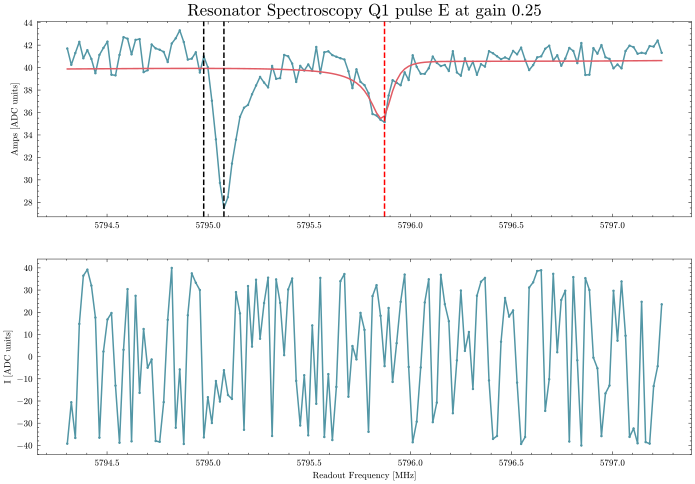

Res freq e 5795.078186047435
Res freq g 5795.78348406068
Chi shift (e-g): -0.7052980132448283
qubit 1 {'Res freq': 5795.78348406068, 'Res freq (yaml)': 5795.78348406068, 'Res kappa': 0.14377117069157014, 'Qubit EF freq': 3347.507450556916, 'T2R EF': 12.886664298134905, 'T2R EF err': 4.539987313794966, 'Pi/2 EF pulse gain': 1605, 'Res chi shift (e - g)': -0.7052980132448283}


In [60]:
# # TESTING
# # rspec_chi = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspec_chi.data = temp_data

rspec_chi.data = rspec_chi.analyze(fit=True)
rspec_chi_fit = rspec_chi.data['fit']
if not isinstance(rspec_chi_fit, (list, np.ndarray)):
    rspec_chi.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
rspec_chi.display(fit=True)
# res_freq_e = rspec_chi_fit[0] - yaml_cfg.hw.soc.dacs.readout.mixer_freq[qubit_i]
res_freq_e = rspec_chi.data['xpts'][np.argmin(rspec_chi.data['amps'])]
# res_freq_e = rspec_chi.data['xpts'][np.argmax(rspec_chi.data['amps'])]
print('Res freq e', res_freq_e)
res_freq_g = yaml_cfg.device.readout.frequency[qubit_i]
print('Res freq g', res_freq_g)
# res_freq_e = -83
# results_Qi.update({'Res chi shift (e - g)': yaml_cfg.device.readout.lo_sideband[qubit_i]*(res_freq_e - yaml_cfg.device.readout.frequency[qubit_i])})
chi_shift_eg = yaml_cfg.device.readout.lo_sideband[qubit_i]*(res_freq_e - res_freq_g)
print('Chi shift (e-g):', chi_shift_eg)
results_Qi.update({'Res chi shift (e - g)': chi_shift_eg})
# res_freq_e = 6953.5
# results_Qi.update({'Res chi shift (e - g)': res_freq_e - (5925 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.hw.soc.dacs.readout.mixer_freq + yaml_cfg.device.readout.frequency[qubit_i]))})
print(f'qubit {qubit_i}', results_Qi)

In [49]:
if save_data: saved_files.append(rspec_chi.save_data())

# Qubit ef spectroscopy

## Pulse Probe EF spectroscopy

In [66]:
qEFspec = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qEFspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 50
npts = 250

qEFspec.cfg.expt = dict(
    start=np.reshape(yaml_cfg.device.qubit.f_ef, (4,4))[qubit_i,qubit_i]-0.5*span, # resonator frequency to be mixed up [MHz]
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=reps, # Number of averages per point
    rounds=rounds, # Number of start to finish sweeps to average over
    length=1, # ef probe constant pulse length [us]
    gain=int(np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.gain, (4,4))[qubit_i, qubit_i]/50), # ef pulse gain
    # gain=5000,
    pulse_type='gauss',
    qTest=qubit_i,
    qZZ=None,
    checkEF=True,
)
# qEFspec.cfg.device.readout.relax_delay = qEFspec.cfg.device.qubit.T1[qubit_i] # Wait time between experiments [us]
qEFspec.go(analyze=False, display=False, progress=True, save=False)

Running pulse probe EF on Q2 


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4572.951668198422, HWHM -0.13245317450681796
Found peak in I at [MHz] 4571.651104485063, HWHM 4.950019715493185
Found peak in Q at [MHz] 4572.94375139564, HWHM -0.256830203823992


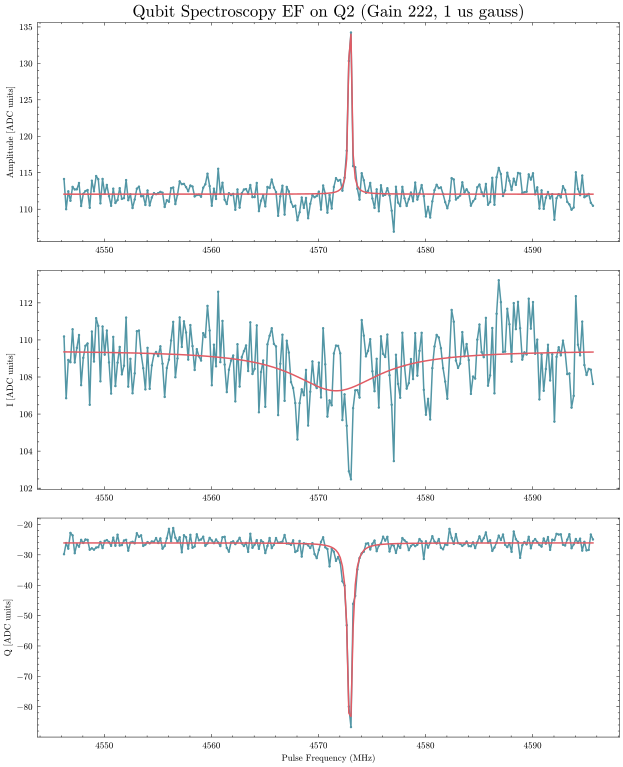

best 2 0.02051036177445805
*Set qubit 2 f_ef to 4572.94375139564*
{'Qubit EF freq': 4572.94375139564, 'T2R EF': 0.8314732142857144, 'T2R EF err': 0.2887390656749924, 'Pi EF pulse gain': 10717, 'T2R': 20.621715224002095, 'T2R err': 1.9381811134510958, 'Qubit freq': 4761.052325526186}


In [68]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec.analyze(data=temp_data, fit=True)

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qEFspec.analyze(fit=True, signs=[1, sign, sign])
        fit_err_i = qEFspec.data['fit_err_avgi'][2][2]
        fit_err_q = qEFspec.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[1] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[2] = sign
            best_fit_err_q = fit_err_q
    except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qEFspec.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qEFspec.analyze(fit=True, signs=best_signs)
qEFspec.display(fit=True, signs=best_signs)

qEFspec_fit, qEFspec_fit_err = meas.fitting.get_best_fit(qEFspec.data)
yaml_cfg.device.qubit.f_ef = np.reshape(yaml_cfg.device.qubit.f_ef, (4,4))
yaml_cfg.device.qubit.f_ef[qubit_i, qubit_i] = qEFspec_fit[2]
print(f'*Set qubit {qubit_i} f_ef to {yaml_cfg.device.qubit.f_ef[qubit_i, qubit_i]}*')
results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i, qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
yaml_cfg.device.qubit.f_ef = yaml_cfg.device.qubit.f_ef.flatten().tolist()
print(results_Qi)

In [107]:
if save_data: saved_files.append(qEFspec.save_data())

## Pulse Probe EF spectroscopy round 2

In [123]:
qEFspec2 = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qEFspec2.cfg = AttrDict(deepcopy(yaml_cfg))

span = 15
npts = 150

qEFspec2.cfg.expt = dict(
    start=np.reshape(yaml_cfg.device.qubit.f_ef, (4,4))[qubit_i,qubit_i]-0.5*span, # resonator frequency to be mixed up [MHz]
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=reps, # Number of averages per point
    rounds=rounds, # Number of start to finish sweeps to average over
    length=1, # ef probe constant pulse length [us]
    gain=int(np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.gain, (4,4))[qubit_i, qubit_i]/80), # ef pulse gain
    pulse_type='gauss',
    qTest=qubit_i,
    qZZ=None,
    checkEF=True,
)
qEFspec2.go(analyze=False, display=False, progress=True, save=False)

Running pulse probe EF on Q2 


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4571.826176722614, HWHM -0.19434895219617748
Found peak in I at [MHz] 4571.829575492035, HWHM -0.19673990858365212
Found peak in Q at [MHz] 4571.825674978509, HWHM 0.1940442781310156


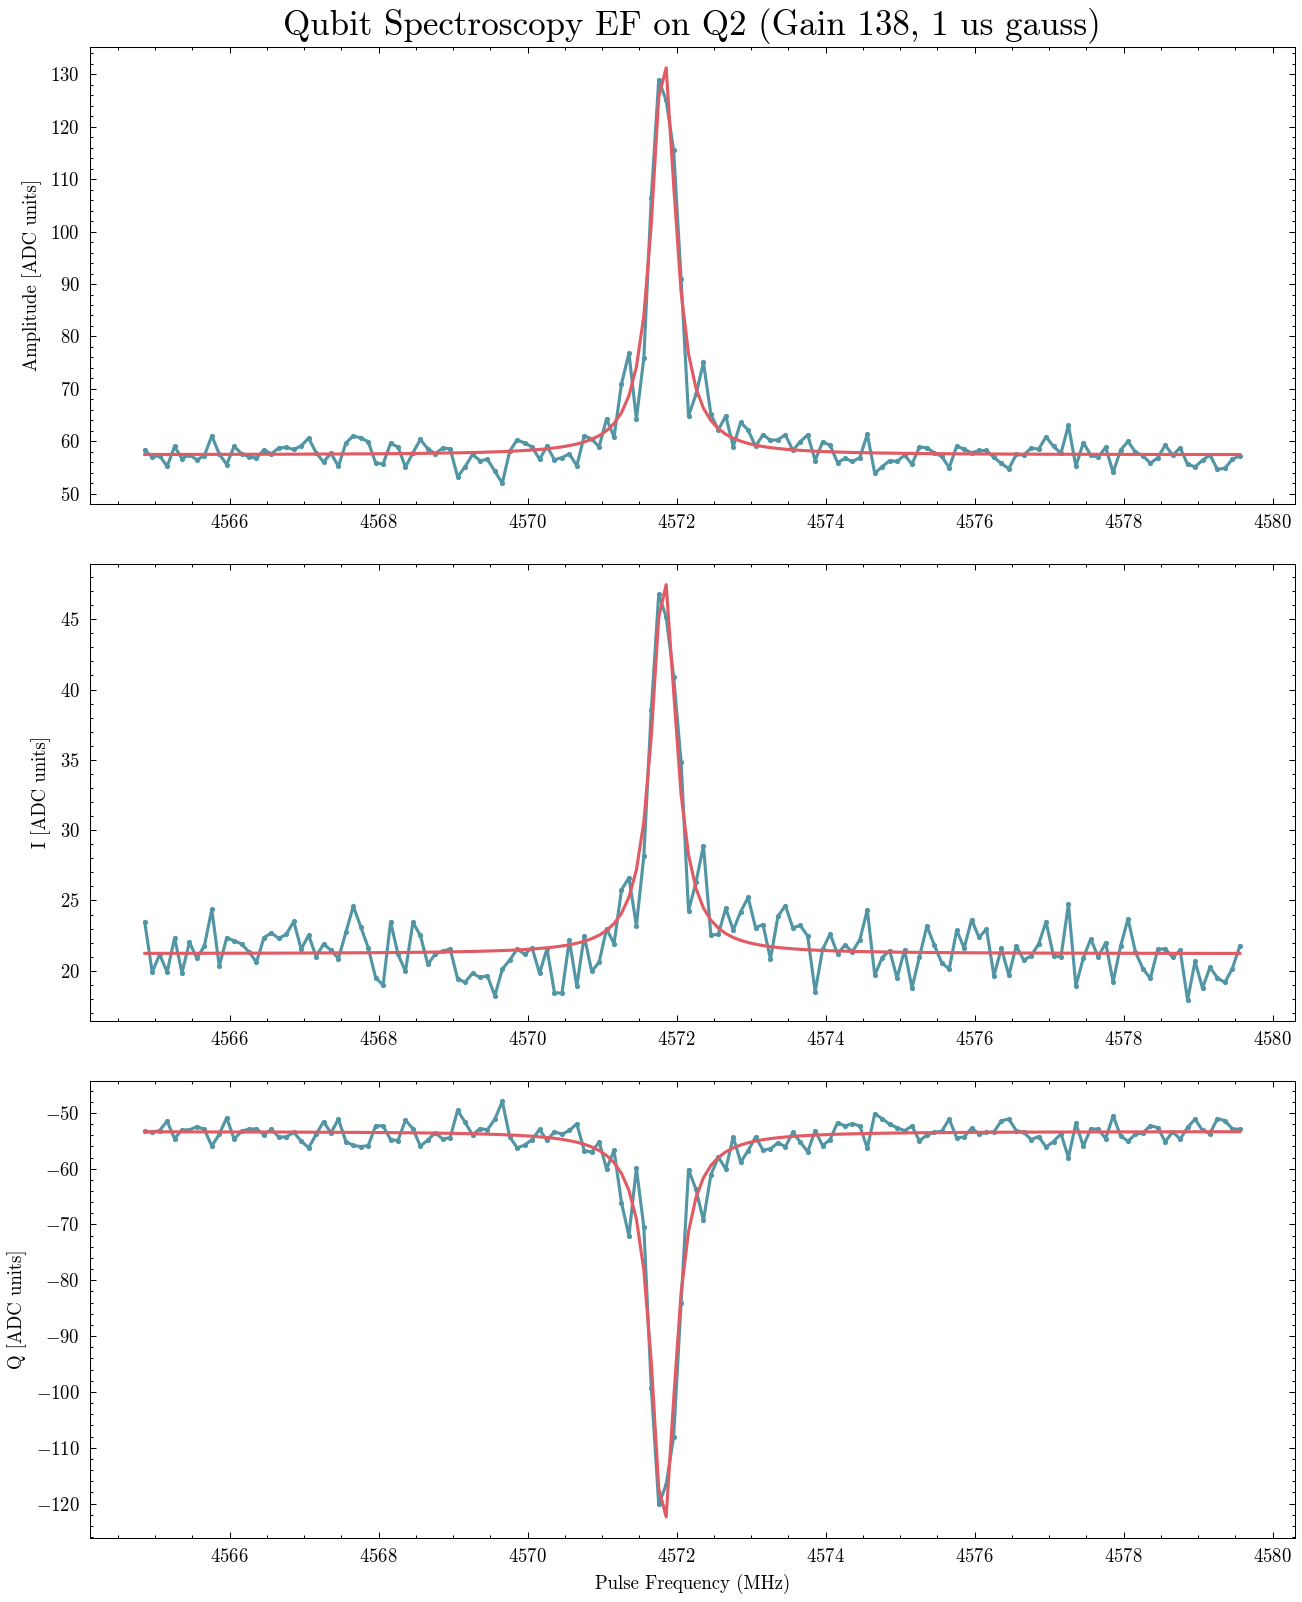

best 2 0.018881062815649927
*Set qubit 2 f_ef to 4571.825674978509*
{'Res freq': 7702.327621781433, 'Res freq (yaml)': 502.32762178143275, 'Res kappa': 0.24292681241212788, 'Qubit freq': 4760.776513809593, 'Pi/2 pulse gain': 20097, 'T2R': 36.1996360724333, 'T2R err': 2.0870895935455347, 'Qubit EF freq': 4571.825674978509, 'Pi/2 EF pulse gain': 6516, 'T2R EF': 0.8314732142857144, 'T2R EF err': 0.3007165740822458}


In [124]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec2.analyze(data=temp_data, fit=True)

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    qEFspec2.analyze(fit=True, signs=[1, sign, sign])
    fit_err_i = qEFspec2.data['fit_err_avgi'][2][2]
    fit_err_q = qEFspec2.data['fit_err_avgq'][2][2]
    if fit_err_i < best_fit_err_i:
        best_signs[1] = sign
        best_fit_err_i = fit_err_i
    if fit_err_q < best_fit_err_q:
        best_signs[2] = sign
        best_fit_err_q = fit_err_q
    # except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qEFspec2.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qEFspec2.analyze(fit=True, signs=best_signs)
qEFspec2.display(fit=True, signs=best_signs)

qEFspec2_fit, qEFspec2_fit_err = meas.fitting.get_best_fit(qEFspec2.data)
yaml_cfg.device.qubit.f_ef = np.reshape(yaml_cfg.device.qubit.f_ef, (4,4))
yaml_cfg.device.qubit.f_ef[qubit_i, qubit_i] = qEFspec2_fit[2]
qubit_hwhm = qEFspec2_fit[3]
print(f'*Set qubit {qubit_i} f_ef to {yaml_cfg.device.qubit.f_ef[qubit_i, qubit_i]}*')
results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i, qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
yaml_cfg.device.qubit.f_ef = yaml_cfg.device.qubit.f_ef.flatten().tolist()
print(results_Qi)

In [110]:
if save_data: saved_files.append(qEFspec2.save_data())

## Amplitude EF Rabi

The EF pi pulse amplitude should be stored in <code>cfg.device.qubit.pulses.pi_ef.gain</code>.

In [46]:
pi_lenEF = np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.sigma, (4,4))[qubit_i, qubit_i]
# pi_lenEF = 0.025
print('qubit', qubit_i, 'pi_lenEF', pi_lenEF)

qubit 3 pi_lenEF 0.03


In [47]:
amprabiEF = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

amprabiEF.cfg = AttrDict(deepcopy(yaml_cfg))


test_pi_half = True
divide_len = True

calib_index = 4*qubit_i + qubit_i
pulse_name = "pi_ef"
gain_name = "gain"
if test_pi_half:
    if divide_len: gain_name = "half_gain"
    else: gain_name = "half_gain_pi_sigma"
old_gain = yaml_cfg.device.qubit.pulses[pulse_name][gain_name][calib_index]

span = min((32000, 1.5*old_gain))
npts = 101

amprabiEF.cfg.expt = dict(
    start=1, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=reps*rounds,
    rounds=1,
    sigma_test=pi_lenEF, # gaussian sigma for pulse length - default from cfg [us]
    pulse_type='gauss' if not use_robust_pulses else 'robust',
    checkEF=True,
    qTest=qubit_i,
    qZZ=None,

    test_pi_half=test_pi_half,
    use_robust_pulses=use_robust_pulses,

    readout_cool=False,
    # n_init_readout=1,
    # n_trig=2,
    # init_read_wait_us=5,
    # singleshot_reps=20000,
    # use_gf_readout=True,

    full_mux_expt=full_mux_expt,
    resonator_reset=resonator_reset,
    
)

# print(amprabiEF.cfg)
amprabiEF.go(analyze=False, display=False, progress=True, save=False)

Running amp rabi EF on Q3 
Calibrating robust pulse


  0%|          | 0/101000 [00:00<?, ?it/s]

(4, 101, 1000)


best 2 0.006329676030163269
Pi gain from amps data [dac units]: 1665
	Pi/2 gain from amps data [dac units]: 832
Pi gain from avgi data [dac units]: 1662
	Pi/2 gain from avgi data [dac units]: 831
Pi gain from avgq data [dac units]: 1673
	Pi/2 gain from avgq data [dac units]: 836


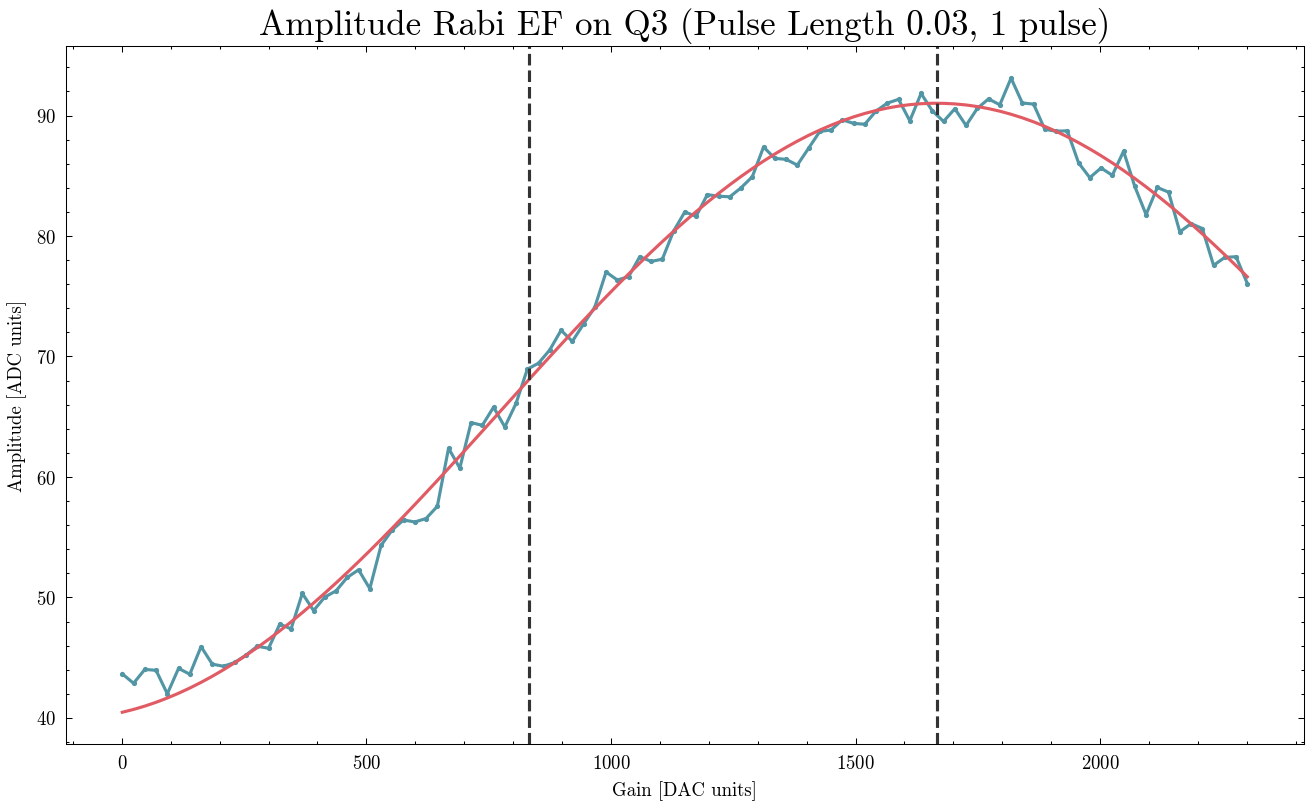

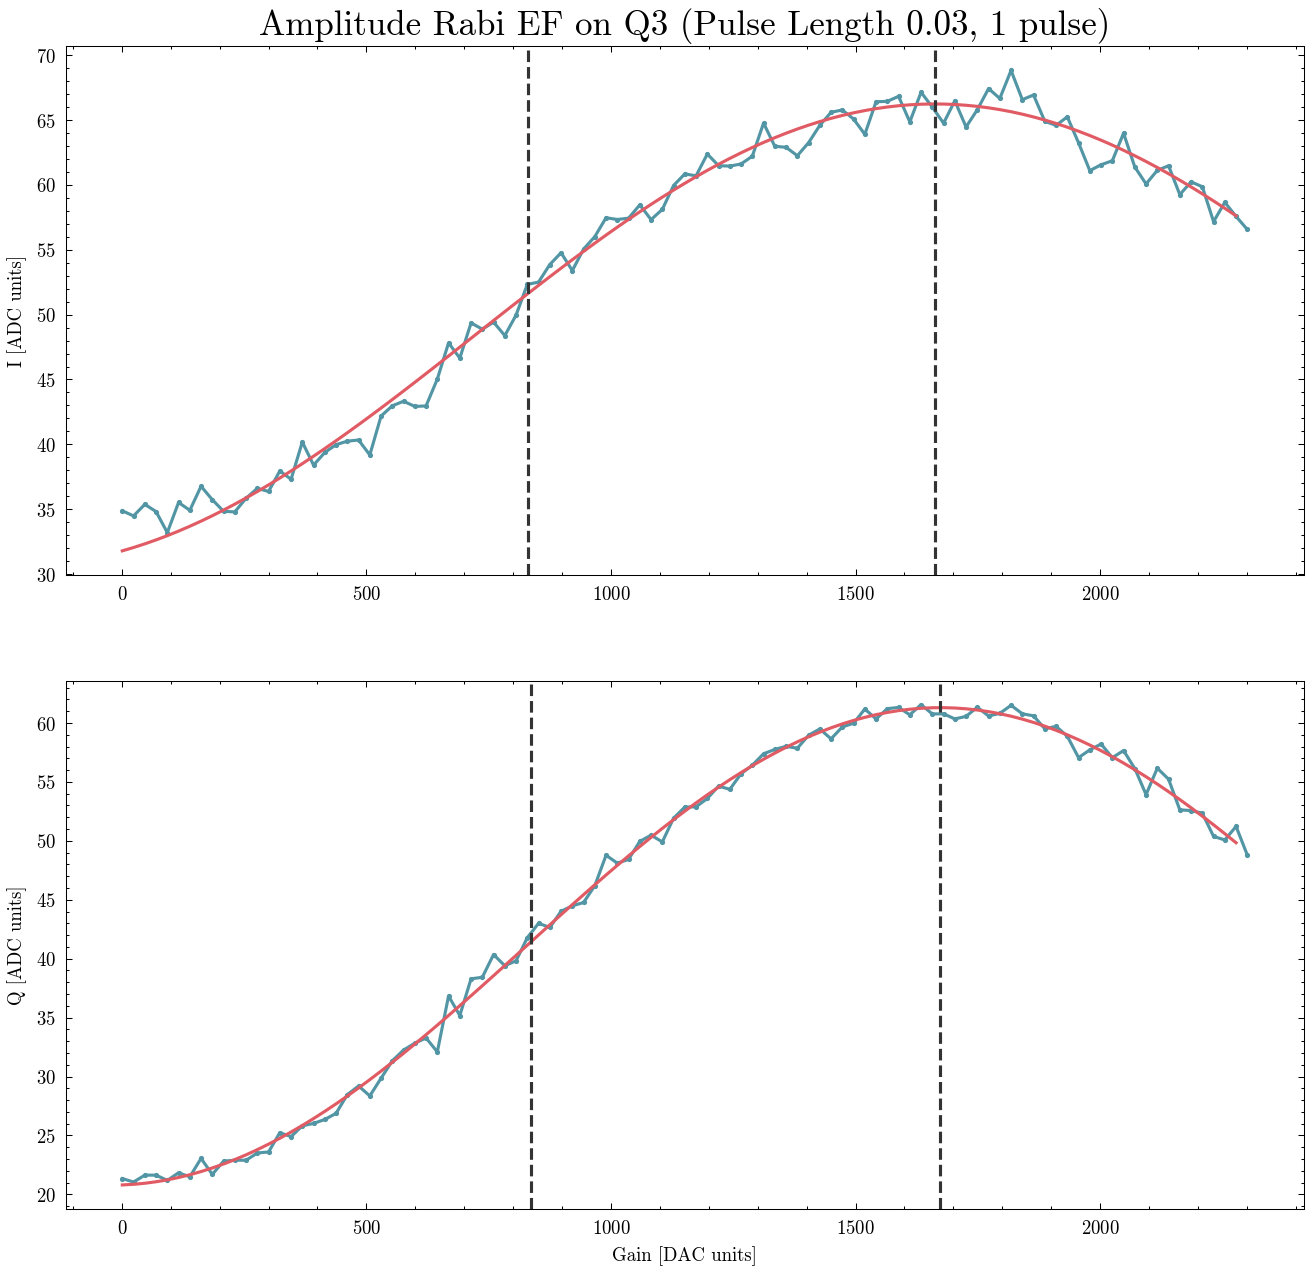

In [48]:
# TESTING
# amprabiEF = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_EF_qubit1.h5')
# amprabiEF.data = temp_data

# amprabiEF.analyze(fit=False)
# amprabiEF.display(fit=False)

amprabiEF.analyze(fit=True, post_select=False)

amprabiEF_fit, amprabiEF_fit_err = meas.fitting.get_best_fit(amprabiEF.data)

p = amprabiEF_fit

if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabiEF.display(fit=False)
    print('WARNING: Fit pi pulse gain is long, please double check!')
    pi_gain = 30000
else: amprabiEF.display(fit=True)


In [21]:
print(f'*Set EF pi pulse sigma for qubit {qubit_i} to {np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.sigma, (4,4))[qubit_i, qubit_i]}*')
yaml_cfg.device.qubit.pulses.pi_ef.gain = np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.gain, (4,4))
yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i, qubit_i] = int(pi_gain)
print(f'*Set EF pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i, qubit_i]}*')
results_Qi.update({'Pi EF pulse gain':yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i, qubit_i]})
print(f'*New pi_ef.gain\n', yaml_cfg.device.qubit.pulses.pi_ef.gain)
yaml_cfg.device.qubit.pulses.pi_ef.gain = yaml_cfg.device.qubit.pulses.pi_ef.gain.flatten().astype(int).tolist()
print(f'*New pi_ef.gain flattened\n{yaml_cfg.device.qubit.pulses.pi_ef.gain}')
print(results_Qi)

*Set EF pi pulse sigma for qubit 2 to 0.015*
*Set EF pi pulse gain for qubit 2 to 11544*
*New pi_ef.gain
 [[ 1245     0     0     0]
 [    0  1945     0     0]
 [    0     0 11544     0]
 [    0     0     0  1500]]
*New pi_ef.gain flattened
[1245, 0, 0, 0, 0, 1945, 0, 0, 0, 0, 11544, 0, 0, 0, 0, 1500]
{'Qubit EF freq': 4572.989442878963, 'T2R EF': 1.7492575590086643, 'T2R EF err': 0.44651201569350935, 'Pi EF pulse gain': 11544}


In [115]:
if save_data: saved_files.append(amprabiEF.save_data())

## Length EF Rabi

In [ ]:
lengthrabiEF = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabiEF_qubit{qubit_i}",
    config_file=config_path,
)
lengthrabiEF.cfg = AttrDict(deepcopy(yaml_cfg))

lengthrabiEF.cfg.expt = dict(
    start=soc.cycles2us(0), # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    expts=121,
    reps=reps*rounds,
    pulse_type='gauss',
    checkEF=True, 
    qTest=qubit_i,
    qZZ=None,
)
# lengthrabiEF.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

import Pyro4.util
try:
    lengthrabiEF.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
# # TESTING
# # lengthrabiEF = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# lengthrabiEF.data = temp_data

lengthrabiEF.analyze(fit=True, fit_func='sin')

lengthrabiEF_fit, lengthrabiEF_fit_err = meas.fitting.get_best_fit(lengthrabiEF.data) #, fitfunc=fitter.decaysin)

lengthrabiEF.display(fit=False, fit_func='sin')
# p = lengthrabiEF_fit
# if p[2] > 180: p[2] = p[2] - 360
# elif p[2] < -180: p[2] = p[2] + 360
# if p[2] < 0: pi_lenEF = (1/2 - p[2]/180)/2/p[1]
# else: pi_lenEF = (3/2 - p[2]/180)/2/p[1]
# pi_lenEF = np.max((0.9*pi_lenEF, 0.015)) # since we run the length rabi at a < max gain

# lengthrabiEF_decay = p[3]

# print(f'Will use sigma {pi_lenEF} for amplitude rabi EF')

In [ ]:
if save_data: saved_files.append(lengthrabiEF.save_data())

## Qubit temperature

In [49]:
amprabiEF2 = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

amprabiEF2.cfg = AttrDict(deepcopy(yaml_cfg))

reps_temp=500
rounds_temp=reps*rounds*100//500

test_pi_half = True
divide_len = True

calib_index = 4*qubit_i + qubit_i
pulse_name = "pi_ef"
gain_name = "gain"
if test_pi_half:
    if divide_len: gain_name = "half_gain"
    else: gain_name = "half_gain_pi_sigma"
old_gain = yaml_cfg.device.qubit.pulses[pulse_name][gain_name][calib_index]

span = old_gain
npts = 4
# reps_temp = 10
# rounds_temp = 10
print('reps', reps_temp, 'rounds', rounds_temp)

amprabiEF2.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts+1,
    reps=reps_temp*rounds_temp,
    rounds=1,
    sigma_test=pi_lenEF, # gaussian sigma for pulse length - default from cfg [us]
    pulse_ge=False, # set to false when measuring qubit temp
    pulse_type='gauss' if not use_robust_pulses else 'robust',
    checkEF=True, 
    qTest=qubit_i,
    qZZ=None,

    test_pi_half=test_pi_half,
    use_robust_pulses=use_robust_pulses,

    readout_cool=False,
    # readout_cool=True,
    # n_init_readout=1,
    # n_trig=1,
    # init_read_wait_us=2,
    # singleshot_reps=10000,
    
    # use_gf_readout=True,
    full_mux_expt=full_mux_expt,
    resonator_reset=resonator_reset,
)

# print(amprabiEF2.cfg)
amprabiEF2.go(analyze=False, display=False, progress=True, save=False)

reps 500 rounds 200
Running amp rabi EF on Q3 
Calibrating robust pulse


  0%|          | 0/500000 [00:00<?, ?it/s]

(4, 5, 100000)


In [50]:
post_select = False
# post_select = True
ps_threshold = None
# ps_threshold = 450

yscale normal: 51.10723643817935
yscale no pulse: 1.9140298990418074
qubit 3
Qubit temp [mK]: 63.26472409618594
Qubit E thermal population (%): 3.745125020322843


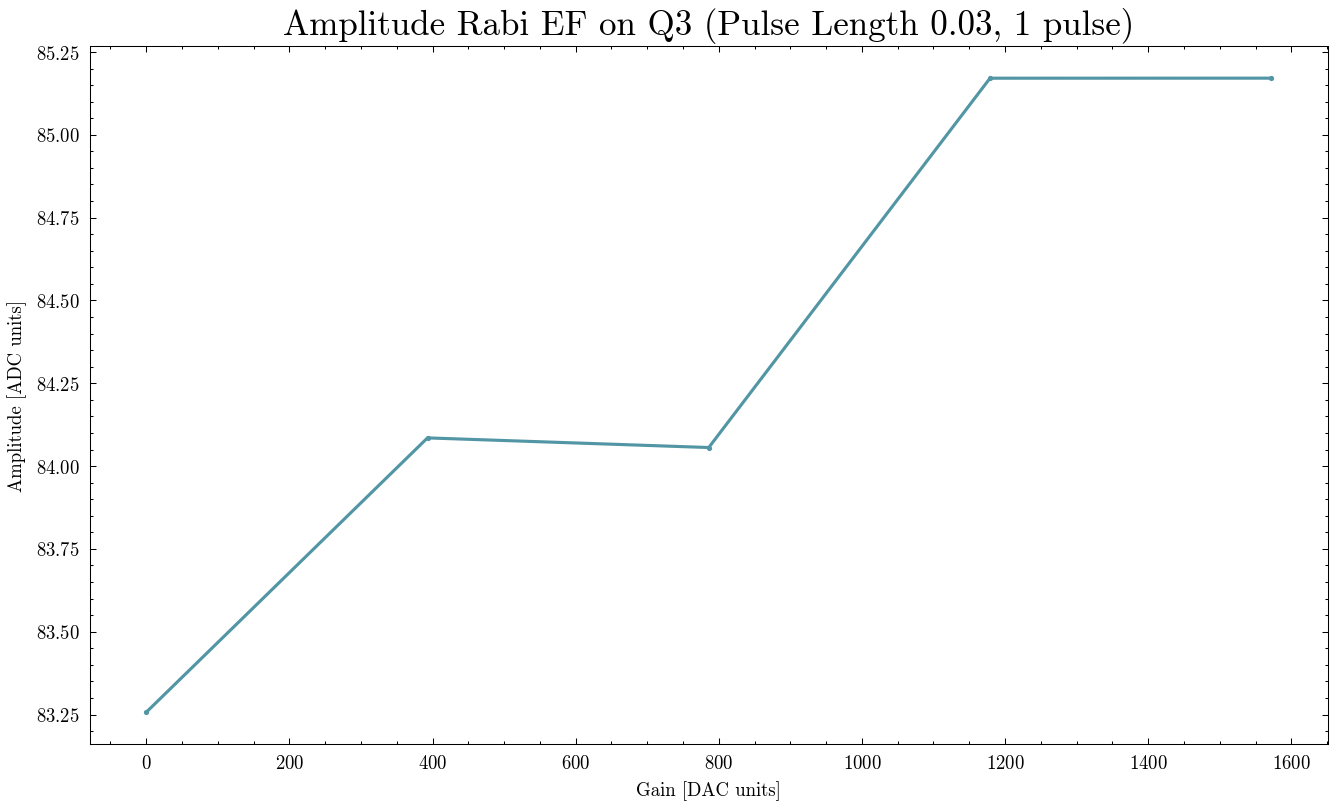

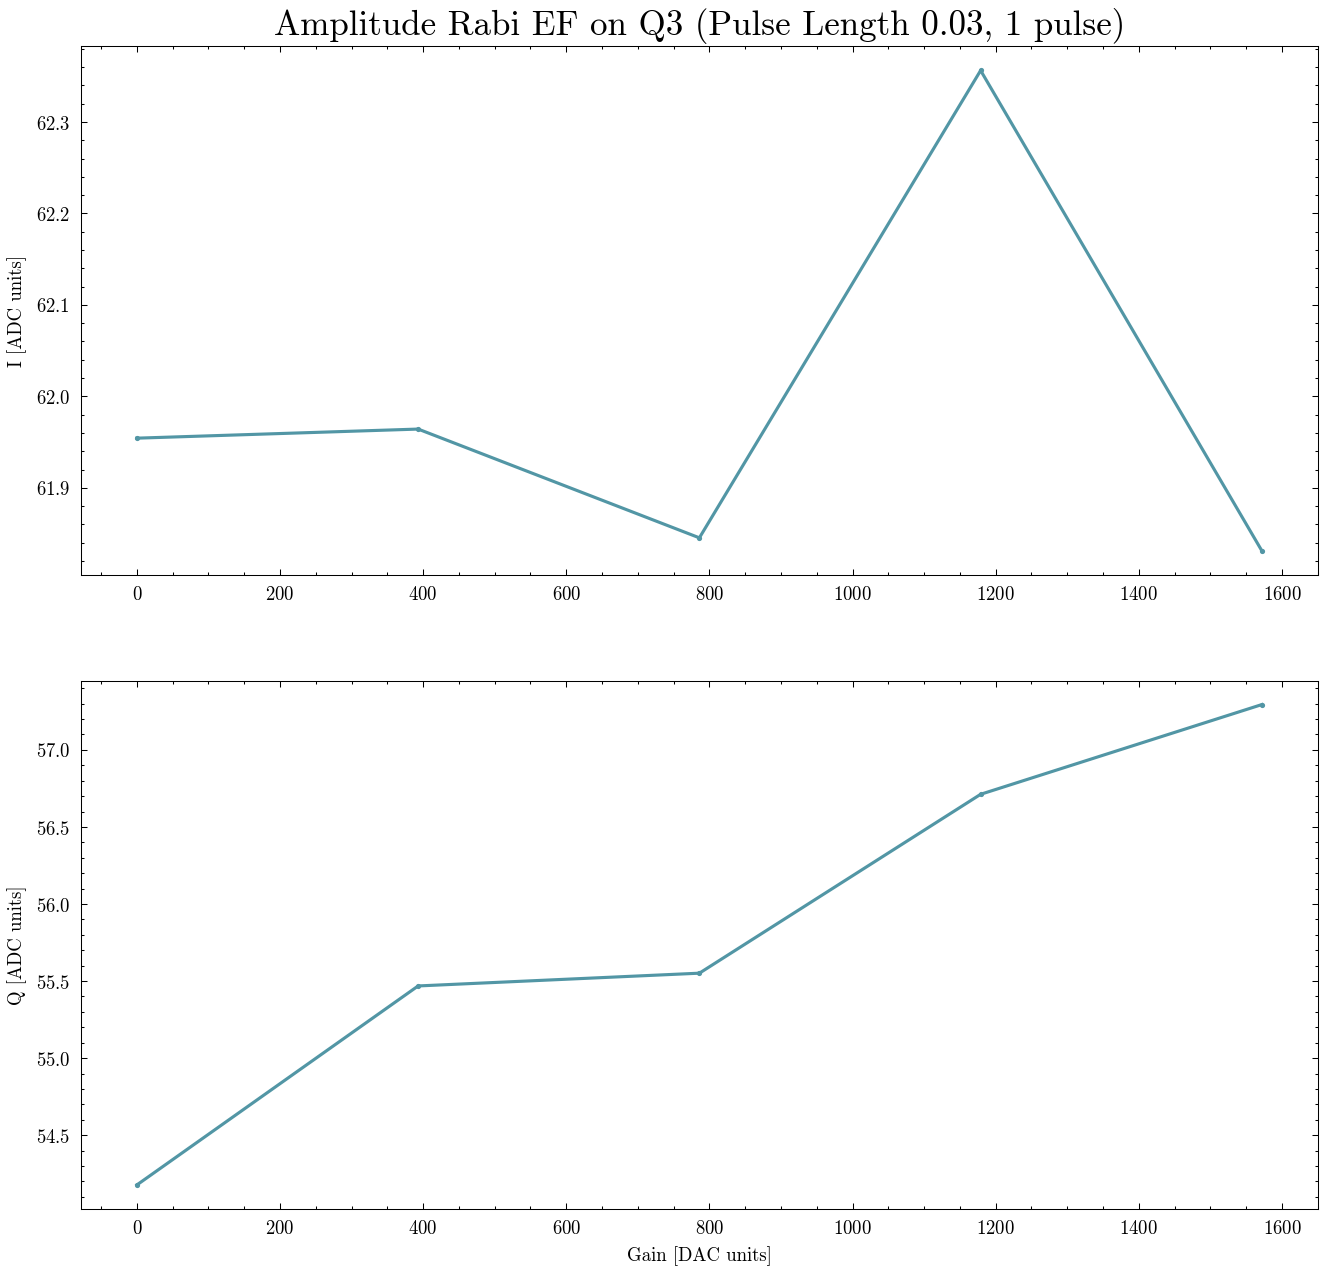

{'Qubit temp [mK]': 63.26472409618594, 'Qubit E thermal population (%)': 3.745125020322843}


In [51]:
# TESTING
# amprabiEF_test = meas.AmplitudeRabiExperiment(config_file=config_path,)
# amprabiEF2 = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00004_amp_rabi_EF_qubit1.h5')
# amprabiEF2.data = temp_data

# amprabiEF2.analyze(fit=False)
# amprabiEF2.display(fit=False)

# fitparams = [None]*4
# fitparams[1] = 2/amprabiEF2.data['xpts'][-1]

# amprabiEF2_fit, amprabiEF2_fit_err = meas.fitting.get_best_fit(amprabiEF2.data)

# NATURAL CONSTANTS
h = 6.62607015e-34
fge = 1e6*(np.reshape(amprabiEF2.cfg.device.qubit.f_ge, (4,4))[qubit_i, qubit_i] + amprabiEF2.cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i])
kB = 1.380649e-23
################

fit_axis = 'amps'
# fit_axis = 'avgi' if post_select else 'amps'

amprabiEF.analyze(fit=False, post_select=post_select, ps_threshold=ps_threshold)
amprabiEF_data = amprabiEF.data[fit_axis]
# amprabiEF2_data = (amprabiEF2.data[fit_axis] + temp_data[fit_axis])/2
# p = amprabiEF.data[f'fit_{fit_axis}']
# efamp_normal = p[0]
efamp_normal = (max(amprabiEF.data[fit_axis]) - min(amprabiEF.data[fit_axis]))

amprabiEF2.analyze(fit=False, post_select=post_select, ps_threshold=ps_threshold)
amprabiEF2_data = amprabiEF2.data[fit_axis]
# p = amprabiEF2.data[f'fit_{fit_axis}']
# efamp_nopulse = p[0]
# fit_vals = meas.fitting.sinfunc(amprabiEF.data['xpts'], *p)
# std_dev_no_pulse = np.std(fit_vals[:10])
# efamp_nopulse = (max(fit_vals) - min(fit_vals))-2*std_dev_no_pulse
efamp_nopulse = (max(amprabiEF2.data[fit_axis]) - min(amprabiEF2.data[fit_axis]))

# amprabiEF2.display(fit=True, fit_func='sin')

print('yscale normal:', efamp_normal)
print('yscale no pulse:', efamp_nopulse)

temp = 1e3*-h*fge/(kB*np.log(efamp_nopulse/(efamp_normal+efamp_nopulse)))

print(f'qubit {qubit_i}')
print('Qubit temp [mK]:', temp)
results_Qi.update({'Qubit temp [mK]':temp})
print('Qubit E thermal population (%):', efamp_nopulse/efamp_normal*100)

amprabiEF2.display(fit=False)
results_Qi.update({'Qubit E thermal population (%)':efamp_nopulse/efamp_normal*100})
print(results_Qi)

In [64]:
if save_data: saved_files.append(amprabiEF2.save_data())

## EF Ramsey Fringe
Update the ef frequency in <code>cfg.qubit.f_ef</code>.

In [107]:
qubitEF_hwhm = 2
# ramseyEF_freq = max((min((np.abs(np.ceil(qubitEF_hwhm)), 3)), 2))
ramseyEF_freq = 3.0
# short_T1 = False

In [92]:
t2EFr = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="ramseyEF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

t2EFr.cfg = AttrDict(deepcopy(yaml_cfg))

t2EFr.cfg.expt = dict(
    start=0, # wait time tau [us]
    # step=soc.cycles2us(10), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    step=soc.cycles2us(4*2), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=151,
    # ramsey_freq=ramseyEF_freq, # [MHz]
    ramsey_freq=ramseyEF_freq/2, # [MHz]
    checkEF=True,
    reps=reps*rounds,
    rounds=1,
    qTest=qubit_i,
    qZZ=None,

    full_mux_expt=full_mux_expt,
    resonator_reset=resonator_reset,
    use_robust_pulses=use_robust_pulses,
)

t2EFr.cfg.device.readout.frequency = t2EFr.cfg.device.readout.frequency_ef
t2EFr.cfg.device.readout.readout_length = t2EFr.cfg.device.readout.readout_length_ef
t2EFr.cfg.device.readout.gain = t2EFr.cfg.device.readout.gain_ef

try:
    t2EFr.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

Running Ramsey EF on Q2 


  0%|          | 0/151000 [00:00<?, ?it/s]

best 1 0.07386383423291124
Current pi pulse frequency: 4572.82121588348
Fit frequency from amps [MHz]: 1.4997235113335587 +/- 0.012890594749610688
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4572.821492372147
 	4569.821492372147
T2 Ramsey from fit amps [us]: 2.984987558710483 +/- 0.6961991964162038


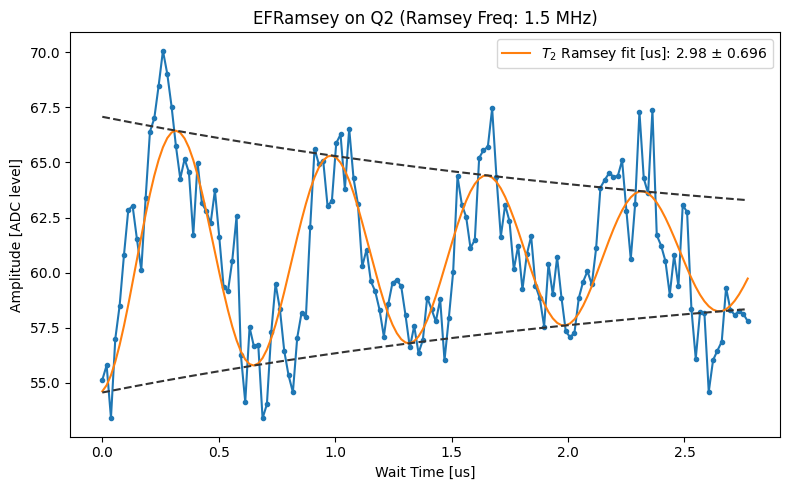

Current pi pulse frequency: 4572.82121588348
Fit frequency from I [MHz]: 1.5144045906560921 +/- 0.007550499073272819
Suggested new pi pulse frequency from fit I [MHz]:
 	4572.806811292824
 	4569.806811292824
T2 Ramsey from fit I [us]: 5.407904612166893 +/- 1.36048349442156
Fit frequency from Q [MHz]: 1.534043039255934 +/- 0.015812709555133544
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4572.787172844224
 	4569.787172844224
T2 Ramsey from fit Q [us]: 2.5547141624069556 +/- 0.675186887343268


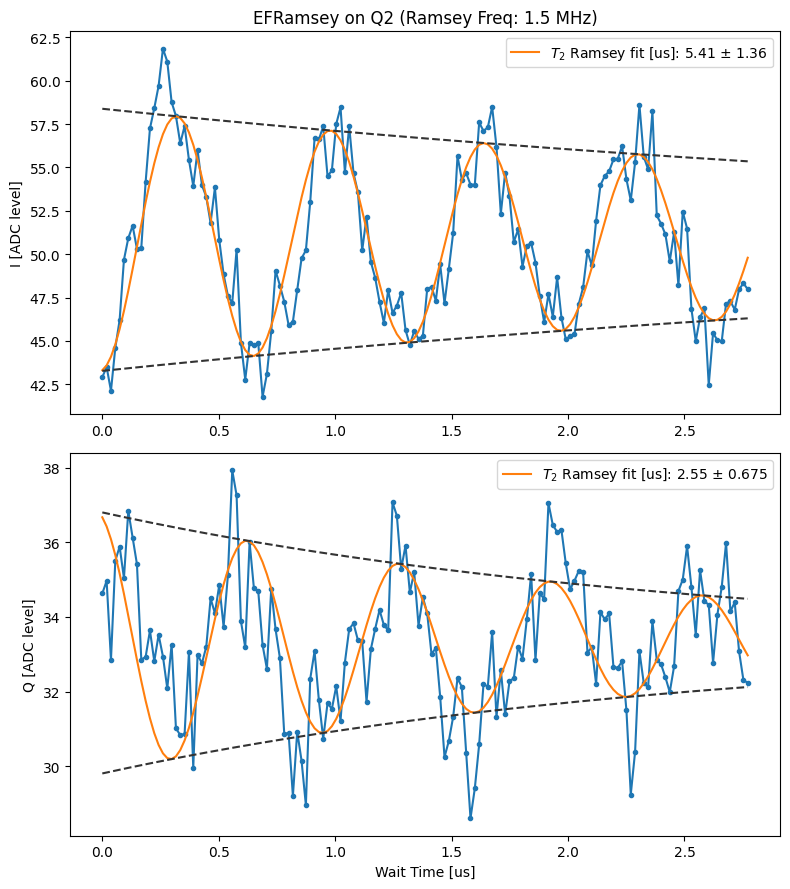

*Set qubit 2 EF freq to 4572.806811292824*
*New f_ef
 [[3882.6760964     0.         3882.59302316 3882.54656679]
 [3345.39573643 3347.50745056 3347.003495   3346.98172934]
 [4572.33082747 4570.95440332 4572.80681129    0.        ]
 [4207.22322553 4202.99489405 4205.11037263 4205.75364196]]
*New f_ef flattened
[3882.6760964004225, 0.0, 3882.593023159515, 3882.5465667921762, 3345.3957364303, 3347.507450556916, 3347.003494996075, 3346.9817293387923, 4572.330827468564, 4570.954403324034, 4572.806811292824, 0.0, 4207.223225529803, 4202.994894046403, 4205.110372632136, 4205.753641959673]
[{}, {'Res freq': 5795.78348406068, 'Res freq (yaml)': 5795.78348406068, 'Res kappa': 0.14377117069157014, 'Qubit EF freq': 3347.507450556916, 'T2R EF': 12.886664298134905, 'T2R EF err': 4.539987313794966, 'Pi/2 EF pulse gain': 1605, 'Res chi shift (e - g)': -0.7052980132448283, 'Res chi shift (f - g)': -1.5, 'Res freq ef (yaml)': 5794.28348406068, 'Single shot g-e fidelity (%)': 49.03354325540691}, {'Pi/2 p

In [94]:
# # TESTING
# # t2EFr = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2EFr.data = temp_data

t2EFr.analyze(fit=True)
t2EFr_fit, t2EFr_fit_err, t2EFr_adjust = meas.fitting.get_best_fit(t2EFr.data, get_best_data_params=['f_adjust_ramsey'])
old_qubit_freq = np.reshape(t2EFr.cfg.device.qubit.f_ef, (4,4))[qubit_i, qubit_i]

if not isinstance(t2EFr_fit, (list, np.ndarray)):
    t2EFr.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
t2EFr.display(fit=True)
yaml_cfg.device.qubit.f_ef = np.reshape(yaml_cfg.device.qubit.f_ef, (4,4))
yaml_cfg.device.qubit.f_ef[qubit_i, qubit_i] = old_qubit_freq + t2EFr_adjust[0]
alt_qubit_freq = old_qubit_freq + t2EFr_adjust[1]
print(f'*Set qubit {qubit_i} EF freq to {yaml_cfg.device.qubit.f_ef[qubit_i, qubit_i]}*')
results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i, qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(f'*New f_ef\n', yaml_cfg.device.qubit.f_ef)
yaml_cfg.device.qubit.f_ef = yaml_cfg.device.qubit.f_ef.flatten().tolist()
print(f'*New f_ef flattened\n{yaml_cfg.device.qubit.f_ef}')
results_Qi.update({'T2R EF':t2EFr_fit[3], 'T2R EF err':np.sqrt(t2EFr_fit_err[3][3])})
print(all_results)

In [64]:
if save_data: saved_files.append(t2EFr.save_data())

## Amplitude EF Rabi round 2

In [31]:
pi_lenEF = np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.sigma, (4,4))[qubit_i, qubit_i]
# pi_lenEF = 0.030
print('qubit', qubit_i, 'pi_lenEF', pi_lenEF)

qubit 2 pi_lenEF 0.015


In [32]:
amprabiEF = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

amprabiEF.cfg = AttrDict(deepcopy(yaml_cfg))

span = min((32000, int(2*np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.gain, (4,4))[qubit_i, qubit_i])))
npts = 101

amprabiEF.cfg.expt = dict(
    start=1, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=reps,
    rounds=rounds,
    sigma_test=pi_lenEF, # gaussian sigma for pulse length - default from cfg [us]
    pulse_type='gauss',
    checkEF=True, 
    qTest=qubit_i,
    qZZ=None,
    resonator_reset=resonator_reset,
    full_mux_expt=full_mux_expt,
)

# print(amprabiEF.cfg)
amprabiEF.go(analyze=False, display=False, progress=True, save=False)

Running amp rabi EF on Q2 


  0%|          | 0/10 [00:00<?, ?it/s]

(4, 101, 100)


best 1 0.05927072234155133
Pi gain from amps data [dac units]: 10404
	Pi/2 gain from amps data [dac units]: 5202
Pi gain from avgi data [dac units]: 10717
	Pi/2 gain from avgi data [dac units]: 5358
Pi gain from avgq data [dac units]: 11097
	Pi/2 gain from avgq data [dac units]: 5548


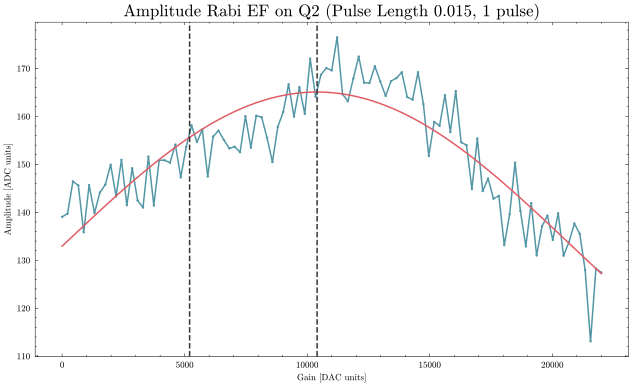

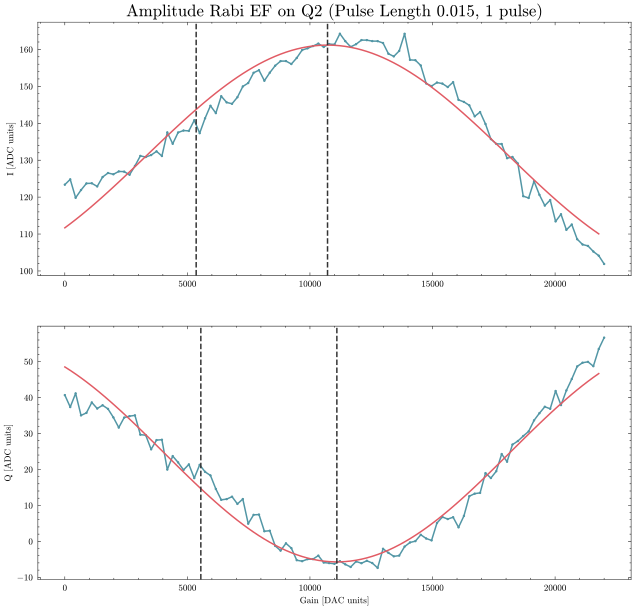

*Set EF pi pulse sigma for qubit 2 to 0.015*
*Set EF pi pulse gain for qubit 2 to 10717*
*New pi_ef.gain
 [[ 1245     0     0     0]
 [    0  1945     0     0]
 [    0     0 10717     0]
 [    0     0     0  1500]]
*New pi_ef.gain flattened
[1245, 0, 0, 0, 0, 1945, 0, 0, 0, 0, 10717, 0, 0, 0, 0, 1500]
{'Qubit EF freq': 4571.919352661604, 'T2R EF': 19.65498884576743, 'T2R EF err': 9.060031074155152, 'Pi EF pulse gain': 10717}


In [33]:
# TESTING
# amprabiEF = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_EF_qubit1.h5')
# amprabiEF.data = temp_data

# amprabiEF.analyze(fit=False)
# amprabiEF.display(fit=False)

amprabiEF.analyze(fit=True)

amprabiEF_fit, amprabiEF_fit_err = meas.fitting.get_best_fit(amprabiEF.data)

p = amprabiEF_fit

if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabiEF.display(fit=False)
    print('WARNING: Fit pi pulse gain is long, please double check!')
    pi_gain = 30000
else: amprabiEF.display(fit=True)

print(f'*Set EF pi pulse sigma for qubit {qubit_i} to {np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.sigma, (4,4))[qubit_i, qubit_i]}*')
yaml_cfg.device.qubit.pulses.pi_ef.gain = np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.gain, (4,4))
yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i, qubit_i] = int(pi_gain)
print(f'*Set EF pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i, qubit_i]}*')
results_Qi.update({'Pi EF pulse gain':yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i, qubit_i]})
print(f'*New pi_ef.gain\n', yaml_cfg.device.qubit.pulses.pi_ef.gain)
yaml_cfg.device.qubit.pulses.pi_ef.gain = yaml_cfg.device.qubit.pulses.pi_ef.gain.flatten().astype(int).tolist()
print(f'*New pi_ef.gain flattened\n{yaml_cfg.device.qubit.pulses.pi_ef.gain}')
print(results_Qi)

In [ ]:
if save_data: saved_files.append(amprabiEF.save_data())

## EF Ramsey Fringe Round 2
Update the T2 EF but not the frequency

In [18]:
# yaml_cfg.device.qubit.f_ge[qubit_i] = 145.572034953271
# qubitEF_hwhm = 7
# short_T1 = False

In [111]:
t2EFr_2 = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="ramseyEF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

t2EFr_2.cfg = AttrDict(deepcopy(yaml_cfg))

t2EFr_2.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(80), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=151,
    ramsey_freq=ramseyEF_freq/10, # [MHz]

    # echo_type='cpmg', # cp or cpmg
    # num_pi=1, # number of pi pulses

    checkEF=True,
    reps=reps*rounds,
    rounds=1,
    qTest=qubit_i,
    qZZ=None,
    full_mux_expt=full_mux_expt,
    resonator_reset=resonator_reset,
    use_robust_pulses=use_robust_pulses,
)

t2EFr_2.cfg.device.readout.frequency = t2EFr_2.cfg.device.readout.frequency_ef
t2EFr_2.cfg.device.readout.readout_length = t2EFr_2.cfg.device.readout.readout_length_ef
t2EFr_2.cfg.device.readout.gain = t2EFr_2.cfg.device.readout.gain_ef

try:
    t2EFr_2.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

Running Ramsey EF on Q3 


  0%|          | 0/151000 [00:00<?, ?it/s]

best 2 0.05426836174388676
Current pi pulse frequency: 4205.753641959673
Fit frequency from amps [MHz]: 0.37309268235873544 +/- 0.0009567704252396624
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4205.680549277314
 	4205.080549277314
T2 Ramsey from fit amps [us]: 28.848525360685915 +/- 4.93849656678176


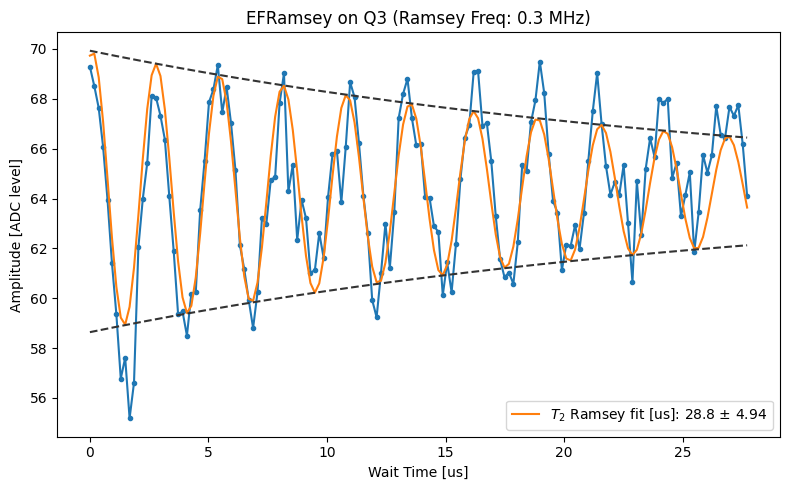

Current pi pulse frequency: 4205.753641959673
Fit frequency from I [MHz]: 0.3733965932882629 +/- 0.0014857450339608484
Suggested new pi pulse frequency from fit I [MHz]:
 	4205.680245366384
 	4205.080245366385
T2 Ramsey from fit I [us]: 20.040480114419964 +/- 3.6774472748449134
Fit frequency from Q [MHz]: 0.3725002815864859 +/- 0.0006962520420583973
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4205.6811416780865
 	4205.081141678086
T2 Ramsey from fit Q [us]: 38.58832430454312 +/- 6.454477409162411


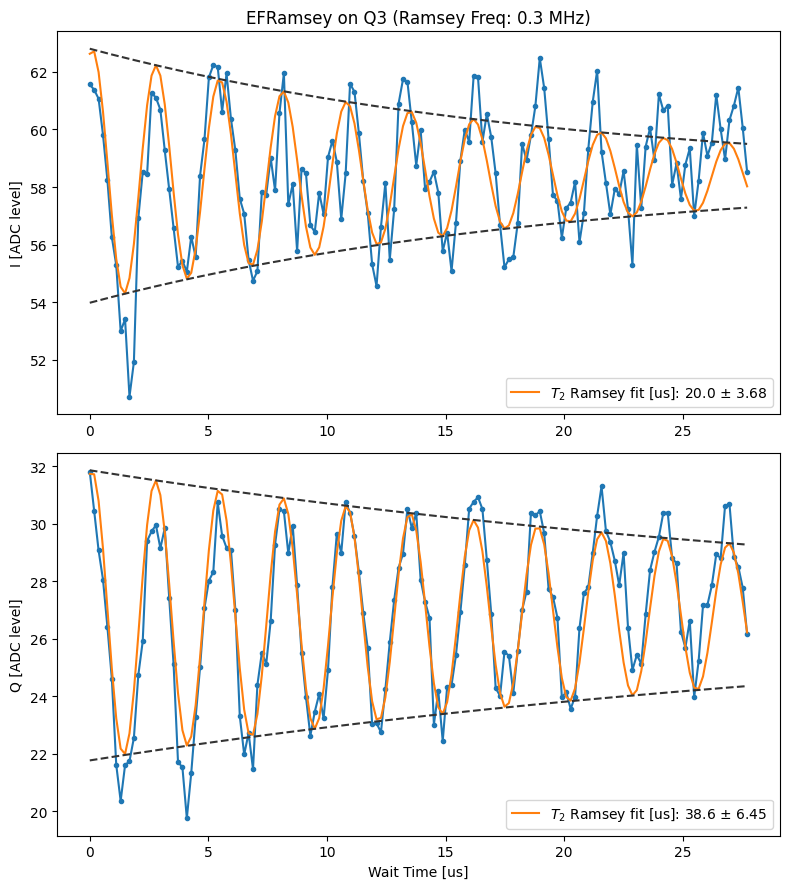

{'T2R EF': 38.58832430454312, 'T2R EF err': 6.454477409162411}


In [112]:
# # TESTING
# # t2EFr_2 = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2EFr_2.data = temp_data

t2EFr_2.analyze(fit=True)
t2EFr_2_fit, t2EFr_2_fit_err, t2EFr_2_adjust = meas.fitting.get_best_fit(t2EFr_2.data, get_best_data_params=['f_adjust_ramsey'])
old_qubit_freq = np.reshape(t2EFr_2.cfg.device.qubit.f_ef, (4,4))[qubit_i, qubit_i]

if not isinstance(t2EFr_2_fit, (list, np.ndarray)):
    t2EFr_2.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
t2EFr_2.display(fit=True)

if t2EFr_2_adjust[0] > ramseyEF_freq/10:
    print('WARNING: your EF frequency is not converging!')
else:
    # yaml_cfg.device.qubit.f_ef = np.reshape(yaml_cfg.device.qubit.f_ef, (4,4))
    # yaml_cfg.device.qubit.f_ef[qubit_i, qubit_i] = old_qubit_freq + t2EFr_2_adjust[0]
    # print(f'*Set qubit {qubit_i} EF freq to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')
    # print(f'*New f_ef\n', yaml_cfg.device.qubit.f_ef)
    # yaml_cfg.device.qubit.f_ef = yaml_cfg.device.qubit.f_ef.flatten().tolist()
    # print(f'*New f_ef flattened\n{yaml_cfg.device.qubit.f_ef}')
    results_Qi.update({'T2R EF':t2EFr_2_fit[3], 'T2R EF err':np.sqrt(t2EFr_2_fit_err[3][3])})
    # results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
    print(results_Qi)

In [ ]:
if save_data: saved_files.append(t2EFr.save_data())

## EF error amplification

In [94]:
npulsecalibEF = meas.NPulseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"NPulseExptEFQ{qubit_i}",
    config_file=config_path,
)

npulsecalibEF.cfg = AttrDict(deepcopy(yaml_cfg))
npulsecalibEF.cfg.expt = dict(
    start=0, # number gate repetitions
    step=1,
    expts=10,
    reps=1000,
    loops=10,
    pulse_type='gauss',
    checkEF=True, 
    qTest=qubit_i,
    qZZ=None,
    test_pi_half=False,
    error_amp=True,
    resonator_reset=resonator_reset,
    full_mux_expt=full_mux_expt,

    post_process='scale',
    singleshot_reps=15000,
    # singleshot_reps=1000,
)

print(npulsecalibEF.cfg)
try:
    npulsecalibEF.acquire(progress=True, debug=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.3682333333336, -278.91333333333296], 'gain': [0.17, 0.025, 0.25, 0.17], 'kappa_ext': [0.157, 0.065, 0.182, 0.104], 'kerr': [-0.0045, 0, 0.008, -0.003], 't_rise_reset': [0.5, 1, 0.5, 0.5], 'readout_length': [4, 4, 4, 4], 'frequency_ef': [-441.91408404503545, -1.5099337748344372, 450.44439227373095, -280.30732891832196], 'gain_ef': [0.001, 0.025, 0.25, 0.17], 'readout_length_ef': [4, 4, 4, 4], 'relax_delay': [450, 450, 450, 225.0]}, 'qubit': {'f_ge': [4111.144520031796, 4105.783958808882, 4111.0028964412795, 4110.5966963096635, 3442.9795552267146, 3448.3482722012286, 3447.233490336077, 3447.0285717924894, 4762.767009306428, 4761.793655204115, 4762.900421466317, 4762.367822139689, 4380.662337410765, 4379.890920412824, 4380.6668186549305, 4381.201533272392], 'f_ef': [3885.3117884920853, 0.0, 0.0, 0.0, 0.0, 3347.8480888529375, 0.0, 0.0, 4571.9056482340775, 4571.070566218902, 

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (3)
g unrotated averages:
Amps 474.855206456419 +/- 385.44830677901336
e unrotated averages:
Amps 1254.0064285520539 +/- 442.2000705777346
ge fidelity (%): 72.42574438295885 	 angle (deg): 0.0 	 threshold ge: 759.4211635666827


  0%|          | 0/10 [00:00<?, ?it/s]

 s:\Connie\experiments\qram_tprocv1_expts\experiments\clifford_averager_program.py: 1877

In [95]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabi.analyze(data=temp_data, fit=True)

data = npulsecalibEF.data
npulsecalibEF.analyze(fit=True)
npulsecalibEF.display(fit=True)

# npulsecalib_fit, npulsecalib_fit_err = meas.fitting.get_best_fit(npulsecalibEF.data)
fit_axis = 'avgi'
npulsecalibEF_fit = data[f'fit_{fit_axis}']
npulsecalibEF_fit_err = data[f'fit_err_{fit_axis}']

angle_err = npulsecalibEF_fit[1]
amp_ratio = (180 - angle_err) / 180
new_amp_ef = np.reshape(npulsecalibEF.cfg.device.qubit.pulses.pi_ef.gain, (4,4))[qubit_i, qubit_i] / amp_ratio

yaml_cfg.device.qubit.pulses.pi_ef.gain = np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.gain, (4,4))
yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i, qubit_i] = int(round(new_amp_ef))
print(f'*Set EF pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i, qubit_i]}*')
results_Qi.update({'Pi EF pulse gain':yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i, qubit_i]})
print(f'*New pi_ef.gain\n', yaml_cfg.device.qubit.pulses.pi_ef.gain)
yaml_cfg.device.qubit.pulses.pi_ef.gain = yaml_cfg.device.qubit.pulses.pi_ef.gain.flatten().tolist()
print(f'*New pi_ef.gain flattened\n{yaml_cfg.device.qubit.pulses.pi_ef.gain}')
print(results_Qi)

fitparams [None, 0.017453292519943295]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
From amps: adjust amplitude to 320 / 0.9978554230773876 = 320.68773952555125
From avgi: adjust amplitude to 320 / 0.9978554230773876 = 320.68773952555125
From avgq: adjust amplitude to 320 / 0.999903037263778 = 320.03103108444986
*Set EF pi pulse gain for qubit 3 to 1095*
*New pi_ef.gain
 [[1280    0    0    0]
 [   0 1912    0    0]
 [   0    0 6380    0]
 [ 300  300    0 1095]]
*New pi_ef.gain flattened
[1280, 0, 0, 0, 0, 1912, 0, 0, 0, 0, 6380, 0, 300, 300, 0, 1095]
{'Res freq': 6971.086666666667, 'Res freq (yaml)': -278.91333333333296, 'Res kappa': 0.19749745591104786, 'Qubit freq': 4381.201533272392, 'Pi pulse gain': 1147, 'T1': 56.17688427668649, 'T1 err': 2.67362068432995, 'T2R': 53.42815301037524, 'T2R err': 7.869086115111744, 'Qubit EF freq': 4381.19346042819, 'T2R EF': 23.803256694009963, 'T2R EF err': 6.133913126035808, 'Pi EF pulse gain': 1095}


In [ ]:
if save_data: npulsecalibEF.save_data()

## (Divide len) Calibrate EF $\pi/2$ pulse
we are using this for everything now

### Amplitude rabi for EF $\pi/2$ pulse (divide len)

In [103]:
pi_lenEF = np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.sigma, (4,4))[qubit_i, qubit_i]
# pi_len = 0.008
print('qubit', qubit_i, 'pi_lenEF', pi_lenEF)

qubit 2 pi_lenEF 0.015


In [104]:
divide_len = True

In [105]:
amprabi_4 = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)
amprabi_4.cfg = AttrDict(deepcopy(yaml_cfg))

n_pulses = 1
span = min((32000, int(1.5*np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.half_gain, (4,4))[qubit_i, qubit_i])))
npts = 151
    
amprabi_4.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=reps*rounds,
    # reps=5,
    rounds=1,
    sigma_test=pi_lenEF, # gaussian sigma for pulse length - overrides config [us]
    pulse_type='gauss' if not use_robust_pulses else 'robust', # EF pulse will always be gauss, need this because will throw an error otherwise even if only using robust for the g
    n_pulses=n_pulses,
    test_pi_half=True,
    divide_len=divide_len,
    qTest=qubit_i,
    qZZ=None,
    checkEF=True, 

    full_mux_expt=full_mux_expt,
    resonator_reset=resonator_reset,
    use_robust_pulses=use_robust_pulses,
)
amprabi_4.go(analyze=False, display=False, progress=True, save=False)

Running amp rabi EF on Q2 
Calibrating robust pulse


  0%|          | 0/10 [00:00<?, ?it/s]

(4, 151, 100)


best 0 0.01024159672776819
Pi gain from amps data [dac units]: 6813
	Pi/2 gain from amps data [dac units]: 3406
Pi gain from avgi data [dac units]: 6848
	Pi/2 gain from avgi data [dac units]: 3424
Pi gain from avgq data [dac units]: 6823
	Pi/2 gain from avgq data [dac units]: 3411


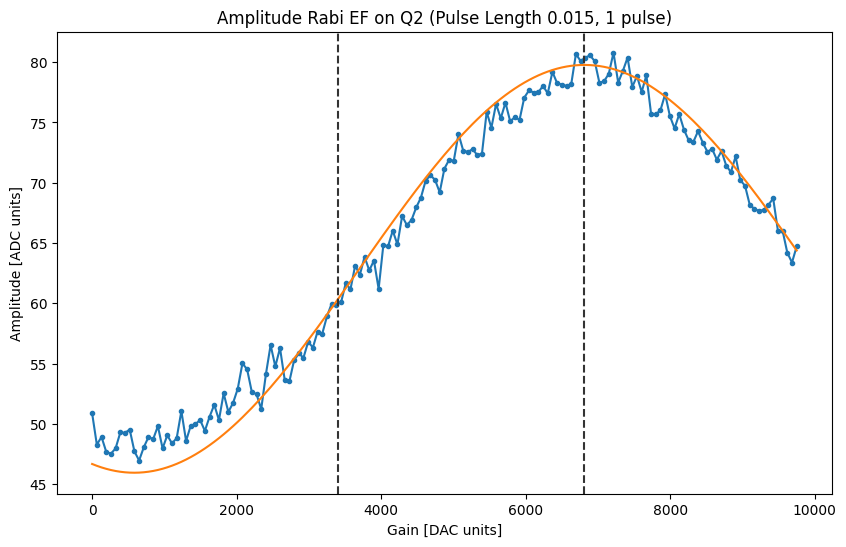

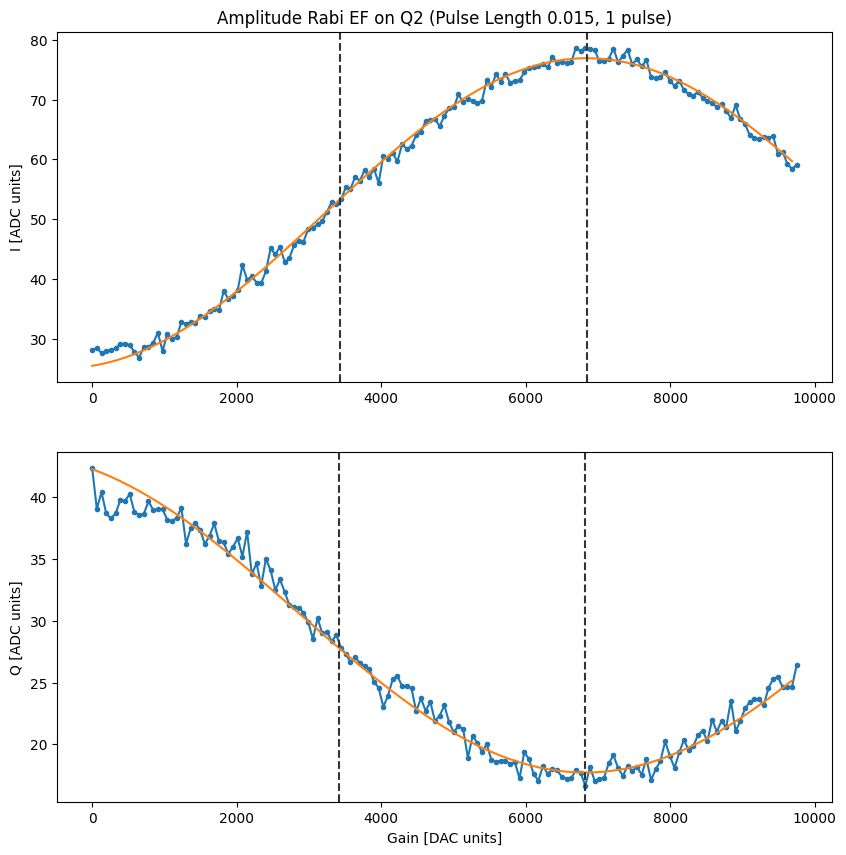

*Set pi/2 EF pulse gain for qubit 2 to 6813*
*New pi_ef.half_gain
 [[1242    0    0    0]
 [   0 1605    0    0]
 [6646 6447 6813    0]
 [1608 1651    0 1575]]
*New pi_ef.half_gain flattened
[1242, 0, 0, 0, 0, 1605, 0, 0, 6646, 6447, 6813, 0, 1608, 1651, 0, 1575]
{'Pi/2 pulse gain': 20280, 'Qubit EF freq': 4572.806811292824, 'T2R EF': 8.314732142857144, 'T2R EF err': 1.2559501580006647, 'T2R': 38.352032306338714, 'T2R err': 3.3057806149267237, 'Qubit freq': 4761.039241045802, 'Pi/2 EF pulse gain': 6813}


In [106]:
# # TESTING
# # amprabi_4 = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# amprabi_4.data = temp_data

amprabi_4.analyze(fit=True)

amprabi_4_fit, amprabi_4_fit_err = meas.fitting.get_best_fit(amprabi_4.data)

p = amprabi_4_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabi_4.display(fit=False)
    print(f'WARNING: Fit pi/2 pulse gain is long ({pi_gain}), please double check!')
    pi_gain = 30000
else: amprabi_4.display(fit=True)

yaml_cfg.device.qubit.pulses.pi_ef.half_gain = np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.half_gain, (4,4))
yaml_cfg.device.qubit.pulses.pi_ef.half_gain[qubit_i, qubit_i] = int(pi_gain)
print(f'*Set pi/2 EF pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.half_gain[qubit_i, qubit_i]}*')
results_Qi.update({'Pi/2 EF pulse gain':yaml_cfg.device.qubit.pulses.pi_ef.half_gain[qubit_i, qubit_i]})
print(f'*New pi_ef.half_gain\n', yaml_cfg.device.qubit.pulses.pi_ef.half_gain)
yaml_cfg.device.qubit.pulses.pi_ef.half_gain = yaml_cfg.device.qubit.pulses.pi_ef.half_gain.flatten().astype(int).tolist()
print(f'*New pi_ef.half_gain flattened\n{yaml_cfg.device.qubit.pulses.pi_ef.half_gain}')
print(results_Qi)

In [ ]:
if save_data: saved_files.append(amprabi_4.save_data())

### EF $\pi/2$, -$\pi/2$ experiment

In [19]:
piminuspi_EF = meas.PiMinusPiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"PiMinusPi_EFExpt{qubit_i}",
    config_file=config_path,
)

span_f = 2.0
npts_f = 35
# npts_f = 50

# span_f = 0.0
# npts_f = 1

piminuspi_EF.cfg = AttrDict(deepcopy(yaml_cfg))
piminuspi_EF.cfg.expt = dict(
    start_N=0, # number gate repetitions
    # step_N=5,
    # step_N=2,
    # expts_N=15,
    step_N=4,
    expts_N=10,
    start_f=piminuspi_EF.cfg.device.qubit.f_ef[qubit_i*4 + qubit_i]-span_f/2,
    step_f=span_f/npts_f,
    expts_f=npts_f+1,
    reps=int(0.75*reps*rounds),
    loops=1,
    # reps=int(2*reps*rounds),
    # loops=5,
    pulse_type='gauss',

    checkEF=True,
    qTest=qubit_i,
    qZZ=None,

    # use_Y=True,

    test_pi_half=True,
    divide_len=divide_len,

    post_process='threshold',
    singleshot_reps=15000,

    full_mux_expt=full_mux_expt,
    resonator_reset=resonator_reset,
)

print(piminuspi_EF.cfg)
try:
    piminuspi_EF.acquire(progress=True, debug=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.3682333333336, -278.89999999999964], 'gain': [0.1, 0.025, 0.25, 0.17], 'kappa_ext': [0.157, 0.065, 0.182, 0.104], 'kerr': [-0.0045, 0, 0.008, -0.003], 't_rise_reset': [0.5, 1, 0.5, 0.5], 'readout_length': [4, 4, 4, 4], 'frequency_ef': [-439.97500000000036, 0.0, 450.44439227373095, -280.30732891832196], 'readout_length_ef': 4, 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.141143385073, 4105.786145933962, 4110.958153299016, 4110.546407850519, 3442.9770233041277, 3448.328289144873, 3447.060317317807, 3446.4929792801067, 4762.761504132457, 4761.823567235975, 4762.898928901032, 4762.369813422167, 4380.698604555338, 4379.604868123916, 4380.717837106693, 4381.175711440575], 'f_ef': [3884.6269161242526, 0.0, 0.0, 0.0, 0.0, 3348.085433174199, 0.0, 0.0, 4571.9056482340775, 4570.996526541673, 4573.168610947125, 0.0, 4211.566315930455, 4205.61697813965, 0.0, 4209.925

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 74.23333333333333 	 angle (deg): 0.0 	 threshold ge: 764.3224091008224


  0%|          | 0/10 [00:00<?, ?it/s]

: 

In [143]:
# # TESTING
# temp_data, attrs = prev_data('s:\Connie\experiments\qramLL_4QR2\data\data_240617\\00000_PiMinusPi_EFExpt0.h5')
# piminuspi_EF.data =  temp_data
# piminuspi_EF.cfg = AttrDict(attrs['config'])


data = piminuspi_EF.data

# piminuspi_EF.analyze(fit=False)
# plt.figure()
# plt.plot(data['cycle_sweep'], data['avgi'][:,0], '.-')
# plt.xlabel('N Cycles $(\pi/2, -\pi/2)^N$')
# plt.ylabel('Avg I')
# plt.show()

piminuspi_EF.analyze(fit=True)
piminuspi_EF.display(fit=True)

yaml_cfg.device.qubit.f_ef = np.reshape(yaml_cfg.device.qubit.f_ef, (4,4))
yaml_cfg.device.qubit.f_ef[qubit_i, qubit_i] = data["best_freq"]
results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i, qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(f'*Set qubit {qubit_i} EF freq to {yaml_cfg.device.qubit.f_ef[qubit_i, qubit_i]}*')
print(results_Qi)
print(f'*New f_ef\n', yaml_cfg.device.qubit.f_ef)
yaml_cfg.device.qubit.f_ef = yaml_cfg.device.qubit.f_ef.flatten().tolist()
print(f'*New f_ef flattened\n{yaml_cfg.device.qubit.f_ef}')

Fit best freq 4573.168610947125 which is 0.08048936338036583 away from old freq 4573.088121583744
*Set qubit 2 EF freq to 4573.168610947125*
{'Res freq': 7702.328233333334, 'Res freq (yaml)': 452.32823333333357, 'Res kappa': 0.2819786993431654, 'Res chi shift (e - g)': -0.943708609271539, 'Res chi shift (f - g)': -1.9172185430463742, 'Res freq ef (yaml)': 450.4510147902872, 'Pi/2 EF pulse gain': 6385, 'Qubit EF freq': 4573.168610947125}
*New f_ef
 [[3884.62691612    0.            0.            0.        ]
 [   0.         3348.08543317    0.            0.        ]
 [4571.90564823 4570.99652654 4573.16861095    0.        ]
 [4211.61773253 4205.61697814    0.         4209.92508626]]
*New f_ef flattened
[3884.6269161242526, 0.0, 0.0, 0.0, 0.0, 3348.085433174199, 0.0, 0.0, 4571.9056482340775, 4570.996526541673, 4573.168610947125, 0.0, 4211.617732525247, 4205.61697813965, 0.0, 4209.925086260656]


In [ ]:
if save_data: piminuspi.save_data()

### EF $\pi/2$ error amplification (divide len)

In [115]:
divide_len = True

In [138]:
npulsecalib_efhalf = meas.NPulseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"NPulseExptEF_half_Q{qubit_i}",
    config_file=config_path,
)

npulsecalib_efhalf.cfg = AttrDict(deepcopy(yaml_cfg))
npulsecalib_efhalf.cfg.expt = dict(
    start=0, # number gate repetitions
    step=1,
    expts=10,
    reps=1000,
    # loops=20,
    loops=5,
    pulse_type='gauss',
    test_pi_half=True,
    divide_len=divide_len,
    error_amp=True,

    checkEF=True,
    qTest=qubit_i,
    qZZ=None,

    # readout_ge=False, # whether to readout at the g/e set point (True) or e/f set point (False)
    readout_ge=True, # whether to readout at the g/e set point (True) or e/f set point (False)

    post_process='scale',
    # post_process=None,
    singleshot_reps=15000,

    full_mux_expt=full_mux_expt,
    resonator_reset=resonator_reset,

    use_robust_pulses=True,
)

print(npulsecalib_efhalf.cfg)
import Pyro4.util
try:
    npulsecalib_efhalf.acquire(progress=True, debug=True)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.3682333333336, -278.89999999999964], 'gain': [0.17, 0.035, 0.25, 0.17], 'kappa_ext': [0.157, 0.065, 0.182, 0.104], 'kerr': [-0.0045, 0, 0.008, -0.003], 't_rise_reset': [0.5, 1, 0.5, 0.5], 'readout_length': [4, 4, 4, 4], 'frequency_ef': [-439.97500000000036, 0.0, 450.44439227373095, -280.30732891832196], 'readout_length_ef': 4, 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.097866562327, 4105.838904759637, 4110.958153299016, 4110.546407850519, 3442.8755721075536, 3448.5530242338505, 3447.060317317807, 3446.4929792801067, 4762.761504132457, 4761.823567235975, 4762.909473544484, 4762.369813422167, 4380.698604555338, 4379.604868123916, 4380.717837106693, 4381.248121020163], 'f_ge_robust': [4114.313815659153, 4108.147701523904, 4114.310372455052, 4114.310372455052, 3443.0032303441935, 3448.345849629168, 0, 0, 4763.941, 4763.941, 4763.941, 4763.941, 4384.2503422

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (2)
g unrotated averages:
Amps 118.20467411805085 +/- 57.38787388991945
e unrotated averages:
Amps 279.91002155643014 +/- 67.09894931806625
ge fidelity (%): 81.78613640909393 	 angle (deg): 0.0 	 threshold ge: 196.18055470399742
thresholds=[0, 0, 196.18055470399742, 0],
angles=[0, 0, 0.0, 0],
ge_avgs=[array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([118.20467412,   0.        , 279.91002156,   0.        ]), array([0., 0., 0., 0.])],
counts_calib=[[13720.0, 1280.0], [1456.0, 13544.0]]


  0%|          | 0/5 [00:00<?, ?it/s]

 s:\Connie\experiments\qram_tprocv1_expts\experiments\clifford_averager_program.py: 1822

In [144]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabi.analyze(data=temp_data, fit=True)

data = npulsecalib_efhalf.data
npulsecalib_efhalf.analyze(fit=True, scale=None)
npulsecalib_efhalf.display(fit=True, scale=None)

# npulsecalib_efhalf_fit, npulsecalib_efhalf_fit_err = meas.fitting.get_best_fit(npulsecalib_efhalf.data)
fit_axis = 'avgi'
npulsecalib_efhalf_fit = data[f'fit_{fit_axis}']
npulsecalib_efhalf_fit_err = data[f'fit_err_{fit_axis}']

angle_err = npulsecalib_efhalf_fit[1]
amp_ratio = (90 - angle_err)/90
new_amp_half_ef = np.reshape(npulsecalib_efhalf.cfg.device.qubit.pulses.pi_ef.half_gain, (4,4))[qubit_i, qubit_i] / amp_ratio

yaml_cfg.device.qubit.pulses.pi_ef.half_gain = np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.half_gain, (4,4))
yaml_cfg.device.qubit.pulses.pi_ef.half_gain[qubit_i, qubit_i] = int(round(new_amp_half_ef))
print(f'*Set pi/2 EF pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.half_gain[qubit_i, qubit_i]}*')
results_Qi.update({'Pi/2 EF pulse gain':yaml_cfg.device.qubit.pulses.pi_ef.half_gain[qubit_i, qubit_i]})
print(f'*New pi_ef.half_gain\n', yaml_cfg.device.qubit.pulses.pi_ef.half_gain)
yaml_cfg.device.qubit.pulses.pi_ef.half_gain = yaml_cfg.device.qubit.pulses.pi_ef.half_gain.flatten().astype(int).tolist()
print(f'*New pi_ef.half_gain flattened\n{yaml_cfg.device.qubit.pulses.pi_ef.half_gain}')
print(results_Qi)

fitparams [None, 0.017453292519943295]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
From amps: adjust amplitude to 6378 / 0.9989780638148239 = 6384.524576690065
From avgi: adjust amplitude to 6378 / 0.9989780638148239 = 6384.524576690065
From avgq: adjust amplitude to 6378 / 1.000193925472444 = 6376.76338314826
*Set pi/2 EF pulse gain for qubit 2 to 6385*
*New pi_ef.half_gain
 [[1261    0    0    0]
 [   0 1941    0    0]
 [   0    0 6385    0]
 [ 340  340    0  320]]
*New pi_ef.half_gain flattened
[1261, 0, 0, 0, 0, 1941, 0, 0, 0, 0, 6385, 0, 340, 340, 0, 320]
{'Res freq': 7702.328233333334, 'Res freq (yaml)': 452.32823333333357, 'Res kappa': 0.2819786993431654, 'Res chi shift (e - g)': -0.943708609271539, 'Res chi shift (f - g)': -1.9172185430463742, 'Res freq ef (yaml)': 450.4510147902872, 'Pi/2 EF pulse gain': 6385, 'Qubit EF freq': 4573.168610947125}


In [ ]:
if save_data: npulsecalib_efhalf.save_data()

## (Divide gain) Calibrate EF $\pi/2$ pulse

### Amplitude rabi for EF $\pi/2$ pulse (divide gain) (use this for RB)

In [ ]:
pi_lenEF = np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.sigma, (4,4))[qubit_i, qubit_i]
# pi_len = 0.008
print('qubit', qubit_i, 'pi_lenEF', pi_lenEF)

In [ ]:
divide_len = False

In [ ]:
amprabi_4 = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)
amprabi_4.cfg = AttrDict(deepcopy(yaml_cfg))

n_pulses = 1
span = min((32000, int(1.5*0.5*np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.gain, (4,4))[qubit_i, qubit_i])))
npts = 151
    
amprabi_4.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=reps,
    # reps=5,
    rounds=rounds,
    sigma_test=pi_lenEF, # gaussian sigma for pulse length - overrides config [us]
    pulse_type='gauss',
    checkEF=True, 
    n_pulses=n_pulses,
    test_pi_half=True,
    divide_len=divide_len,
    qTest=qubit_i,
    qZZ=None,
)
amprabi_4.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# # amprabi_4 = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# amprabi_4.data = temp_data

amprabi_4.analyze(fit=True)

amprabi_4_fit, amprabi_4_fit_err = meas.fitting.get_best_fit(amprabi_4.data)

p = amprabi_4_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabi_4.display(fit=False)
    print(f'WARNING: Fit pi/2 pulse gain is long ({pi_gain}), please double check!')
    pi_gain = 30000
else: amprabi_4.display(fit=True)

yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma = np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma, (4,4))
yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma[qubit_i, qubit_i] = int(pi_gain)
print(f'*Set EF pi/2 pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma[qubit_i, qubit_i]}*')
results_Qi.update({'Pi/2 EF pulse gain':yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma[qubit_i, qubit_i]})
print(f'*New pi_ef.half_gain_pi_sigma\n', yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma)
yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma = yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma.flatten().astype(int).tolist()
print(f'*New pi_ef.half_gain_pi_sigma flattened\n{yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma}')
print(results_Qi)

In [ ]:
if save_data: saved_files.append(amprabi_4.save_data())

### EF $\pi/2$ error amplification (divide gain)

this is mostly only necessary for RB

In [ ]:
divide_len = False

In [ ]:
npulsecalib_efhalf = meas.NPulseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"NPulseExptEF_half_Q{qubit_i}",
    config_file=config_path,
)

npulsecalib_efhalf.cfg = AttrDict(deepcopy(yaml_cfg))
npulsecalib_efhalf.cfg.expt = dict(
    start=0, # number gate repetitions
    step=1,
    expts=10,
    reps=1000,
    loops=20,
    pulse_type='gauss',
    test_pi_half=True,
    divide_len=divide_len,
    error_amp=True,

    checkEF=True, 
    qTest=qubit_i,
    qZZ=None,

    readout_ge=False, # whether to readout at the g/e set point (True) or e/f set point (False)

    post_process='scale',
    singleshot_reps=15000,
)

print(npulsecalib_efhalf.cfg)
import Pyro4.util
try:
    npulsecalib_efhalf.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabi.analyze(data=temp_data, fit=True)

data = npulsecalib_efhalf.data
npulsecalib_efhalf.analyze(fit=True, scale=None)
npulsecalib_efhalf.display(fit=True, scale=None)

# npulsecalib_efhalf_fit, npulsecalib_efhalf_fit_err = meas.fitting.get_best_fit(npulsecalib_efhalf.data)
fit_axis = 'avgi'
npulsecalib_efhalf_fit = data[f'fit_{fit_axis}']
npulsecalib_efhalf_fit_err = data[f'fit_err_{fit_axis}']

angle_err = npulsecalib_efhalf_fit[1]
amp_ratio = (90 - angle_err)/90
new_amp_half_ef = np.reshape(npulsecalib_efhalf.cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma, (4,4))[qubit_i, qubit_i] / amp_ratio

yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma = np.reshape(yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma, (4,4))
yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma[qubit_i, qubit_i] = int(round(new_amp_half_ef))
print(f'*Set pi/2 pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma[qubit_i, qubit_i]}*')
results_Qi.update({'Pi/2 pulse gain':yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma[qubit_i, qubit_i]})
print(f'*New pi_ef.half_gain_pi_sigma\n', yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma)
yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma = yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma.flatten().astype(int).tolist()
print(f'*New pi_ef.half_gain_pi_sigma flattened\n{yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma}')
print(results_Qi)

In [ ]:
if save_data: npulsecalib_efhalf.save_data()

## Resonator chi shift (e/f)

In [61]:
rspecEF_chi = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_chi_qubit{qubit_i}",
    config_file=config_path,
)
rspecEF_chi.cfg = AttrDict(deepcopy(yaml_cfg))

span = 1.5 # MHz
npts = 151
rspecEF_chi.cfg.expt = dict(
    start=rspecEF_chi.cfg.device.readout.frequency[qubit_i]-abs(results_Qi['Res chi shift (e - g)'])-span, # [MHz]
    # start=rspecEF_chi.cfg.device.readout.frequency[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=reps*rounds,
    pulse_e=True, # add ge pi pulse prior to measurement
    pulse_f=True, # add ef pi pulse prior to measurement
    qTest=qubit_i,
    qZZ=None,

    full_mux_expt=full_mux_expt,
    resonator_reset=resonator_reset,
)

# rspecEF_chi.cfg.device.readout.gain[qubit_i] /= 2
rspecEF_chi.cfg.device.readout.gain = rspecEF_chi.cfg.device.readout.gain_ef
# rspecEF_chi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]
rspecEF_chi.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/151 [00:00<?, ?it/s]

electrical delay phase correction (no mux support) (deg) 1.2808348093872866
param guess [5794.323219160018, 28971.61609580009, 28971.61609580009, 0, -0.0710215272167339, 0.945078539942226]
param bounds ([5793.58811982227, 0, 0, -6.283185307179586, -0.10653229082510085, -inf], [5795.058318497767, 1000000000.0, 100000000.0, 6.283185307179586, 0.10653229082510085, 1.0171802053676835])
popt [ 5.79427105e+03  6.42182017e+04  2.12568338e+05  5.87163988e-01
 -1.65851728e-03 -3.29298788e-02]

Freq with minimum transmission: 5794.273550285846
Freq with maximum transmission: 5793.667590020946
From fit:
	f0: 5794.271050777036
	Qi: 64218.20170605794 	 kappa_i/2pi: 0.09022786214567016
	Qe: 212568.33803874408 	 kappa_e/2pi: 0.027258391838773915
	Q0: 49318.71477955399
	kappa [MHz]: 0.11748625398444407
	phi [radians]: 0.587163988341415
baseline 96.50573679836319


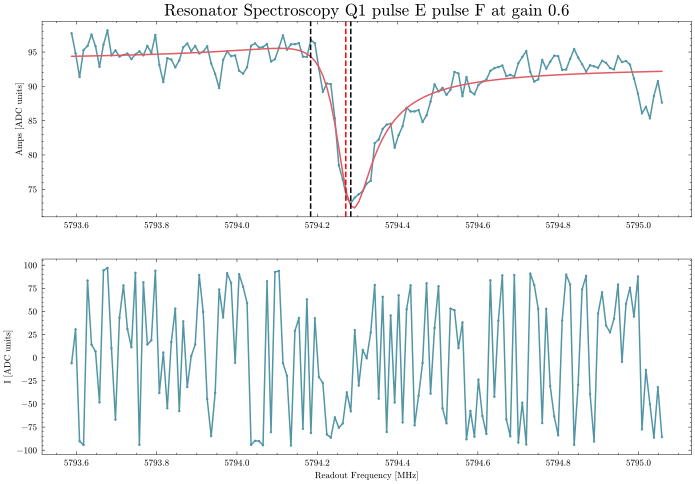

ef chi shift -1.5
Res freq ef: 5794.28348406068
[{}, {'Res freq': 5795.78348406068, 'Res freq (yaml)': 5795.78348406068, 'Res kappa': 0.14377117069157014, 'Qubit EF freq': 3347.507450556916, 'T2R EF': 12.886664298134905, 'T2R EF err': 4.539987313794966, 'Pi/2 EF pulse gain': 1605, 'Res chi shift (e - g)': -0.7052980132448283, 'Res chi shift (f - g)': -1.5, 'Res freq ef (yaml)': 5794.28348406068}, {}, {}]


In [62]:
# # TESTING
# # rspecEF_chi = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspecEF_chi.data = temp_data

rspecEF_chi.data = rspecEF_chi.analyze(fit=True)
rspecEF_chi_fit = rspecEF_chi.data['fit']
rspecEF_chi.display(fit=True)
# res_freq_f = rspecEF_chi_fit[0] - yaml_cfg.hw.soc.dacs.readout.mixer_freq[qubit_i]
res_freq_f = rspecEF_chi.data['xpts'][np.argmin(rspecEF_chi.data['amps'])]
print('ef chi shift', yaml_cfg.device.readout.lo_sideband[qubit_i]*(res_freq_f - yaml_cfg.device.readout.frequency[qubit_i]))
results_Qi.update({'Res chi shift (f - g)': yaml_cfg.device.readout.lo_sideband[qubit_i]*(res_freq_f - yaml_cfg.device.readout.frequency[qubit_i])})
results_Qi.update({'Res freq ef (yaml)':res_freq_f})

print('Res freq ef:', res_freq_f)

# yaml_cfg.device.readout.frequency_ef = [0]*4
yaml_cfg.device.readout.frequency_ef[qubit_i] = res_freq_f
# res_freq_f = 6953.5
print(all_results)

In [ ]:
if save_data: saved_files.append(rspecEF_chi.save_data())

## $T_1$ EF

In [137]:
t1EF = meas.T1Experiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"t1EF_qubit{qubit_i}",
    config_file=config_path,
)
t1EF.cfg = AttrDict(deepcopy(yaml_cfg))

span = 100
npts = 121

t1EF.cfg.expt = dict(
    start=0, # wait time [us]
    step=span/npts,
    expts=npts,
    reps=reps*rounds*4,
    rounds=1,
    qTest=qubit_i,
    qZZ=None,
    # qZZ=0,
    checkEF=True,

    full_mux_expt=full_mux_expt,
    resonator_reset=resonator_reset,
)

# for q in range(4):
#     if q != qubit_i:
#         t1EF.cfg.device.readout.gain[q] = 1e-4

t1EF.cfg.device.readout.relax_delay = span # Wait time between experiments [us]
t1EF.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/484000 [00:00<?, ?it/s]

In [138]:
# # TESTING
# # t1EF = meas.T1Experiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_t1EF_qubit1.h5')
# t1EF.data = temp_data

t1EF.analyze(fit_log=False)

t1EF_fit, t1EF_fit_err = meas.fitting.get_best_fit(t1EF.data) #, fitter.expfunc)

t1EF.display(fit=True, fit_log=False)
t1EF_qubit = t1EF_fit[3]
yaml_cfg.device.readout.relax_delay[qubit_i] = np.round(4*t1EF_qubit)
print(f'*Set readout {qubit_i} relax delay to {yaml_cfg.device.readout.relax_delay[qubit_i]}*')
results_Qi.update({'T1_EF':t1EF_qubit, 'T1_EF err':np.sqrt(t1EF_fit_err[3][3])})
print(f'qubit {qubit_i}', results_Qi)

best 0 113353.36745871502
Fit T1 amps [us]: 21.222524604661047
Fit T1 avgi [us]: 20.052374595554404
Fit T1 avgq [us]: 29.517732509264814
*Set readout 3 relax delay to 85.0*
qubit 3 {'Pi pulse gain': 14360, 'Qubit freq': 4381.135527846996, 'Res freq': 6971.153333333334, 'Res freq (yaml)': -228.84666666666666, 'Res kappa': 0.20149515995222483, 'Pi/2 pulse gain': 3120, 'Single shot g-e fidelity (%)': 2.2249999999999934, 'T1_EF': 21.222524604661047, 'T1_EF err': 1.2097921499036397}


In [ ]:
if save_data: saved_files.append(t1.save_data())

# Single Shot

In [63]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

## Single shot optimization

In [29]:
results_Qi['Res kappa'] = 0.2
# print(results_Qi['Res kappa'])

In [30]:
qubit_i = 2

In [ ]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)
shotopt.cfg = AttrDict(deepcopy(yaml_cfg))

# span_f = 2*abs(results_Qi['Res chi shift (f - g)']) # MHz
# span_f = 2*abs(results_Qi['Res chi shift (e - g)']) # MHz

span_f = 1.0*abs(results_Qi['Res kappa']) # MHz
npts_f = 15
# span_f = 0
# npts_f = 1

span_gain = 0.4
npts_gain = 8
# span_gain = 0.0
# npts_gain = 8

# span_len = 5 # us
# npts_len = 10
span_len = 0 # us
npts_len = 1

shotopt.cfg.expt = dict(
    reps=15000,
    qTest=qubit_i,

    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] - span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] + 0.25*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i],
    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - span_f/2, # [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2,
    start_gain=0.2,
    step_gain=span_gain/npts_gain,
    expts_gain=npts_gain + 1,
    # start_gain=0.2,
    # step_gain=0,
    # expts_gain=1,

    start_len=shotopt.cfg.device.readout.readout_length[qubit_i],
    step_len=span_len/npts_len,
    expts_len=npts_len,
    # start_len=7,
    # step_len=span_len/npts_len,
    # expts_len=npts_len + 1,

    full_mux_expt=full_mux_expt,
    resonator_reset=resonator_reset,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
imax = shotopt.analyze()
shotopt.display()
print(shotopt.data['fid'])

freq_opt = shotopt.data['fpts'][imax[0]]
gain_opt = shotopt.data['gainpts'][imax[1]]
len_opt = shotopt.data['lenpts'][imax[2]]

In [ ]:

# Using readlines()
file1 = open('C:\\Users\\slab\\Downloads\\singleshot_opt.txt', 'r')
lines = file1.readlines()
freqs = []
gains = []
lengths = []
fids = []

line = lines[0]
words = line.split()
freq = float(words[1][:-1])
freqs.append(freq)
gain = float(words[3][:-1])
gains.append(gain)
length = float(words[5])
lengths.append(length)

fid_line = lines[1]
fids.append(float(fid_line.split()[3]))
 
# Strips the newline character
for i in range(2, len(lines), 2):
    line = lines[i]
    words = line.split()
    freq = float(words[1][:-1])
    if freq not in freqs: freqs.append(freq)
    gain = float(words[3][:-1])
    if gain not in gains: gains.append(gain)
    length = float(words[5])
    if length not in lengths: lengths.append(length)

    fid_line = lines[i+1]
    fids.append(float(fid_line.split()[3]))
    continue

fids = np.append(fids, [0]*22)
fids = np.reshape(fids, newshape=(len(freqs), len(gains), len(lengths)))

# lenpts = [data['lenpts'][0]]
for g_ind, gain in enumerate(gains):
    for l_ind, l in enumerate(lengths):
        plt.plot(freqs, fids[:,g_ind, l_ind], 'o-', label=f'gain: {gain:.2}, len [us]: {l}')
plt.xlabel('Frequency [MHz]')
plt.ylabel(f'Fidelity [%]')
plt.legend()
plt.show()


In [ ]:
if save_data: saved_files.append(shotopt.save_data())

next qubit

In [ ]:
qubit_i = 2
results_Qi = all_results[qubit_i]
results_Qi['Res kappa'] = 0.2
# print(results_Qi['Res kappa'])

In [ ]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)
shotopt.cfg = AttrDict(deepcopy(yaml_cfg))

# span_f = 2*abs(results_Qi['Res chi shift (f - g)']) # MHz
# span_f = 2*abs(results_Qi['Res chi shift (e - g)']) # MHz

# span_f = 2*abs(results_Qi['Res kappa']) # MHz
# npts_f = 15

span_f = 3*abs(results_Qi['Res kappa']) # MHz
npts_f = 20

# span_gain = 0.85
# npts_gain = 5
span_gain = 0.6
npts_gain = 6

span_len = 0 # us
npts_len = 1

shotopt.cfg.expt = dict(
    reps=20000,
    qTest=qubit_i,

    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.75*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] + 0.25*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i],
    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - span_f/2, # [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2),
    start_gain=0.1,
    # start_gain=0.10,
    step_gain=span_gain/npts_gain,
    expts_gain=npts_gain + 1,

    start_len=5,
    # step_len=span_len/npts_len,
    # expts_len=npts_len + 1,
    step_len=0,
    expts_len=1,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
imax = shotopt.analyze()
shotopt.display()
print(shotopt.data['fid'])

freq_opt = shotopt.data['fpts'][imax[0]]
gain_opt = shotopt.data['gainpts'][imax[1]]
len_opt = shotopt.data['lenpts'][imax[2]]

In [ ]:
if save_data: saved_files.append(shotopt.save_data())

next qubit

In [ ]:
qubit_i = 3
results_Qi = all_results[qubit_i]
results_Qi['Res kappa'] = 0.2
# print(results_Qi['Res kappa'])

In [ ]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)
shotopt.cfg = AttrDict(deepcopy(yaml_cfg))

# span_f = 2*abs(results_Qi['Res chi shift (f - g)']) # MHz
# span_f = 2*abs(results_Qi['Res chi shift (e - g)']) # MHz

# span_f = 2*abs(results_Qi['Res kappa']) # MHz
# npts_f = 15

span_f = 3*abs(results_Qi['Res kappa']) # MHz
npts_f = 20

# span_gain = 0.85
# npts_gain = 5
span_gain = 0.1
npts_gain = 8

span_len = 0 # us
npts_len = 1

shotopt.cfg.expt = dict(
    reps=15000,
    qTest=qubit_i,

    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.75*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] + 0.25*span_f,
    # start_f=shotopt.cfg.device.readout.frequency[qubit_i],
    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - span_f/2, # [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2),
    start_gain=0.01,
    # start_gain=0.10,
    step_gain=span_gain/npts_gain,
    expts_gain=npts_gain + 1,

    start_len=8.0,
    # step_len=span_len/npts_len,
    # expts_len=npts_len + 1,
    step_len=0,
    expts_len=1,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
imax = shotopt.analyze()
shotopt.display()
print(shotopt.data['fid'])

freq_opt = shotopt.data['fpts'][imax[0]]
gain_opt = shotopt.data['gainpts'][imax[1]]
len_opt = shotopt.data['lenpts'][imax[2]]

In [ ]:
if save_data: saved_files.append(shotopt.save_data())

## Best readout parameters

In [15]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [64]:
qubit_i = 1

In [74]:
shot = meas.HistogramExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_qubit{qubit_i}",
    config_file=config_path,
)
shot.cfg = AttrDict(deepcopy(yaml_cfg))

shot.cfg.expt = dict(
    reps=8000,
    check_f=False,
    qTest=qubit_i,

    use_robust_pulses=use_robust_pulses,
    full_mux_expt=full_mux_expt,
    resonator_reset=resonator_reset,
)

# shot.cfg.device.readout.frequency[qubit_i] = shot.cfg.device.readout.frequency_ef[qubit_i]
# shot.cfg.device.readout.gain = shot.cfg.device.readout.gain_ef
# shot.cfg.device.readout.readout_length = shot.cfg.device.readout.readout_length_ef[qubit_i]

shot.cfg.device.readout.gain[qubit_i] = 0.9
shot.cfg.device.readout.readout_length = 12

# shot.cfg.device.readout.frequency=freq_opt
# shot.cfg.device.readout.gain[qubit_i]=gain_opt
# print(freq_opt, gain_opt)
# shot.cfg.device.readout.readout_length = len_opt # [us]

# shot.cfg.device.readout.frequency=-807.4996158081035
# shot.cfg.device.readout.gain[qubit_i] = 0.85
# shot.cfg.device.readout.readout_length = 2.0 # [us]
# shot.cfg.device.readout.relax_delay = 70 # Wait time between experiments [us]
print(shot.cfg)

shot.go(analyze=False, display=False, progress=True, save=False)

{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-390.00045219204236, 5795.770150727347, 502.42095511476606, -228.8557536534039], 'gain': [0.6, 0.9, 0.5, 0.3], 'readout_length': 12, 'frequency_ef': [-390.0004521920423, 5795.770150727347, 500.48386902205084, -230.30732892], 'gain_ef': [0.5, 0.5, 0.4, 0.25], 'readout_length_ef': [4.5, 16, 10, 8], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4108.755047003828, 4103.366954082312, 4108.649372291309, 4108.232503550693, 3442.591941352887, 3447.981518133789, 3446.872635941306, 3446.65966586083, 4760.911839134516, 4759.946893523059, 4761.052602755913, 4760.46101643607, 4377.996318964773, 4377.247239665757, 4377.995764386313, 4378.454058265707], 'f_ef': [3882.6760964004225, 0.0, 3882.593023159515, 3882.5465667921762, 3345.3957364303, 3347.507450556916, 3347.003494996075, 3346.9817293387923, 4572.330827468564, 4570.954403324034, 4572.82121588348, 0.0, 4207.223225529803, 4202.994894046403, 4205.110

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

In [75]:
# # TESTING
# shot = meas.HistogramExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00001_single_shot_qubit0.h5')
# data = shot.analyze(data=temp_data)
# shot.display(data=data)

shot.analyze(verbose=False)
shot.display(verbose=True, amplitude_mode=shot.cfg.expt.full_mux_expt)
results_Qi.update({'Single shot g-e fidelity (%)': 100*shot.data['fids'][0]})

g unrotated averages:
I 55.66259970157352 +/- 14.863710700435346 	 Q -62.057314161692894 +/- 17.746863734645164 	 Amp 84.90086862857402 +/- 16.64808760238183
Rotated (theta=1.4487026278570774):
I 68.37452888681621 +/- 17.689944502261362 	 Q 47.690240574006324 +/- 14.931407559544171 	 Amp 83.36327276745234 +/- 16.64808760238183
e unrotated averages:
I 61.59471618963646 +/- 14.861317250100795 	 Q -110.40223918204015 +/- 21.722007917006227 	 Amp 127.46821100731492 +/- 20.6669552629199
Rotated (theta=1.4487026278570774):
I 117.08204146188974 +/- 21.8623780355509 	 Q 47.69024057400632 +/- 14.654037156541063 	 Amp 126.42216371700914 +/- 20.6669552629199
ge fidelity (%): 79.79909832479059
rotation angle (deg): 83.00454634572205
threshold ge: 92.56879048914661


In [ ]:
if save_data: saved_files.append(shot.save_data())

In [ ]:
# TESTING
shot = meas.HistogramExperiment(config_file=config_path)
temp_data, attrs = prev_data('S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00000_single_shot_qubit2.h5')
shot.cfg = AttrDict(attrs['config'])
shot.data = temp_data

In [ ]:
# Checking for drift vs. shot number

data = shot.data

Ies = data['Ie']
Qes = data['Qe']
Igs = data['Ig']
Qgs = data['Qg']

plot_e = False

if plot_e:
    i, q = Ies, Qes
else:
    i, q = Igs, Qgs

amps = np.abs(i+1j*q)
phases = np.angle(i+1j*q)

# plt.plot(amps, '.', label='amps')
# plt.ylabel('Amps [ADC units]')
# plt.xlabel('Shot number')
# plt.legend()
# plt.show()

plt.title(f'Q{shot.cfg.expt.qTest} {"e" if plot_e else "g"}')
plt.plot(phases, '.', label='phases')
plt.axhline(0, color='r')
# plt.axhline(1.5, color='r')
plt.ylabel('Phases [radians]')
plt.xlabel('Shot number')
plt.legend()
plt.show()

plt.plot(i, '.', label='i')
plt.ylabel('I [ADC units]')
plt.xlabel('Shot number')
plt.legend()
plt.show()

plt.plot(q, '.', label='Q')
plt.ylabel('Q [ADC units]')
plt.xlabel('Shot number')
plt.legend()
plt.show()

# Results

In [52]:
print(yaml_cfg)
for Qi, results in enumerate(all_results):
    print(f'Qubit {Qi}')
    for key, value in results.items():
        print(f'\t{key}: {value}')
    print()

for saved_file in saved_files:
    print(saved_file)

print(f'f_ge\n{yaml_cfg.device.qubit.f_ge}')
print(f'pi_ge.gain\n{yaml_cfg.device.qubit.pulses.pi_ge.gain}')
print(f'pi_ge.half_gain\n{yaml_cfg.device.qubit.pulses.pi_ge.half_gain}')
print(f'pi_ge.half_gain_pi_sigma\n{yaml_cfg.device.qubit.pulses.pi_ge.half_gain_pi_sigma}')
print(f'f_ef\n{yaml_cfg.device.qubit.f_ef}')
print(f'pi_ef.gain\n{yaml_cfg.device.qubit.pulses.pi_ef.gain}')
print(f'pi_ef.half_gain\n{yaml_cfg.device.qubit.pulses.pi_ef.half_gain}')
print(f'pi_ef.half_gain_pi_sigma\n{yaml_cfg.device.qubit.pulses.pi_ef.half_gain_pi_sigma}')
print(f'readout.frequency_ef\n{yaml_cfg.device.readout.frequency_ef}')

{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-390.00045219204236, 5795.770150727347, 502.42095511476606, -228.8557536534039], 'gain': [0.6, 0.5, 0.5, 0.3], 'readout_length': [4.5, 16, 6.0, 10], 'frequency_ef': [-390.0004521920423, 5795.76166666, 500.48386902205084, -230.30732892], 'gain_ef': [0.5, 0.6, 0.4, 0.25], 'readout_length_ef': [4.5, 20, 10, 8], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4108.755047003828, 4103.366954082312, 4108.649372291309, 4108.232503550693, 3442.591941352887, 3447.981518133789, 3446.872635941306, 3446.65966586083, 4760.911839134516, 4759.946893523059, 4761.052602755913, 4760.46101643607, 4377.996318964773, 4377.247239665757, 4377.995764386313, 4378.454058265707], 'f_ef': [3882.6760964004225, 0.0, 3882.593023159515, 3882.5465667921762, 3345.3957364303, 3347.511433910277, 3347.003494996075, 3346.9817293387923, 4572.523325892487, 4571.192833780465, 4573.063027684978, 0.0, 4207.223225529803, 4202.994894046